In [1]:
import numpy as np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pickle

from helper.read_GEOSldas import read_tilecoord, read_obs_param
from helper.util import make_folder, array2grid
from helper.plot import plotMap
from helper.smapeasev2 import smapeasev2_ind2latlon

import warnings; warnings.filterwarnings("ignore")
import sys 
import io

#sys.stdout = io.TextIOWrapper(open(sys.stdout.fileno(), 'wb', 0), write_through=True)
#sys.stderr = io.TextIOWrapper(open(sys.stderr.fileno(), 'wb', 0), write_through=True)

In [2]:
expdir = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/'
expid = 'LS_DAv8_M36'
domain = 'SMAP_EASEv2_M36_GLOBAL'

start_time = datetime(2000,6,1)
end_time = datetime(2024,4,1)

start_date_str = start_time.strftime('%Y/%m/%d')
end_date_str = end_time.strftime('%Y/%m/%d')

In [3]:
expdir = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_Aus/'
expid = 'DAv8_M36_Aus'
domain = 'SMAP_EASEv2_M36_GLOBAL'

start_time = datetime(2018,8,1)
end_time = datetime(2024,7,1)

start_date_str = start_time.strftime('%Y/%m/%d')
end_date_str = end_time.strftime('%Y/%m/%d')

In [4]:
# Define a minimum threshold for the temporal data points to ensure statistical reliability
# of the computed metrics. 
Nmin = 20

# Base directory for storing monthly files
# This can be the same as the experiment directory (expdir) or a different location
out_path_mo = expdir+expid+'/output/'+domain+'/ana/ens_avg/'

# Directory for diagnostic plots
out_path = expdir+expid+'/output/'+domain+'/figures/'
make_folder(out_path)

# Variable list for computing sum and sum of squared
var_list = ['obs_obs', 'obs_obsvar','obs_fcst','obs_fcstvar','obs_ana','obs_anavar']

In [5]:
# Read tilecoord and obsparam for tile and obs species information
ftc = os.path.join(expdir, expid, 'output', domain, 'rc_out', f'{expid}.ldas_tilecoord.bin')
tc = read_tilecoord(ftc)
n_tile = tc['N_tile']

# Construct the file path dynamically using start_time
fop = os.path.join(
    expdir, expid, 'output', domain, 'rc_out',
    'Y' + start_time.strftime('%Y'),
    'M' + start_time.strftime('%m'),
    f"{expid}.ldas_obsparam.{start_time.strftime('%Y%m%d')}_0000z.txt"
)
obs_param = read_obs_param(fop)
n_spec = len(obs_param)

reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_Aus/DAv8_M36_Aus/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_Aus.ldas_tilecoord.bin
done reading file
Reading /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_Aus/DAv8_M36_Aus/output/SMAP_EASEv2_M36_GLOBAL/rc_out/Y2018/M08/DAv8_M36_Aus.ldas_obsparam.20180801_0000z.txt
Done reading obs_param for 12 species


In [6]:
species_groups = {
    "SMOS": [0, 1, 2, 3],
    "SMAP": [4, 5, 6, 7],
    "ASCAT": [8, 9, 10],
    "MODIS": [11, 12]
}

In [7]:
species_groups = {
    "SMOS": [0, 1, 2, 3],
    "SMAP": [4, 5, 6, 7],
    "ASCAT": [8, 9, 10],
    "CYGNSS": [11]
}

In [8]:

# Load the lists of monthly data from the file

with open(out_path + f'monthly_OmF_data_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'rb') as f:
    monthly_data = pickle.load(f)

# Extract the data from the loaded dictionary
N_data_group_all_months = monthly_data['N_data_group_all_months']
OmF_mean_all_months = monthly_data['OmF_mean_all_months']
OmF_stdv_all_months = monthly_data['OmF_stdv_all_months']
monthly_timestamps = monthly_data['monthly_timestamps']

# Load the group_metrics dictionary from the file
with open(out_path + f'group_metrics_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'rb') as f:
    loaded_group_metrics = pickle.load(f)

print("loaded_group_metrics keys:", loaded_group_metrics.keys())    


loaded_group_metrics keys: dict_keys(['SMOS', 'SMAP', 'ASCAT', 'CYGNSS'])


0 N_data (in millions): [0.03002, 0.029581, 0.03049, 0.029567, 0.029622, 0.030433, 0.027336, 0.030055, 0.028944, 0.030795, 0.029362, 0.03018, 0.030194, 0.02954, 0.030797, 0.029771, 0.030452, 0.03009, 0.028043, 0.029798, 0.029857, 0.030357, 0.029243, 0.030372, 0.030174, 0.029086, 0.030591, 0.029461, 0.030152, 0.030407, 0.027335, 0.030021, 0.029475, 0.030117, 0.028994, 0.029982, 0.02954, 0.029274, 0.02999, 0.028713, 0.030283, 0.030023, 0.027386, 0.030216, 0.029571, 0.029221, 0.029367, 0.029717, 0.02981, 0.028792, 0.030187, 0.028765, 0.030102, 0.030285, 0.027167, 0.030151, 0.029291, 0.030138, 0.029487, 0.029733, 0.030495, 0.024916, 0.030331, 0.029104, 0.029488, 0.030206, 0.023445, 0.025461, 0.029652, 0.029479, 0.028602]
1 N_data (in millions): [0.029106, 0.029266, 0.030385, 0.028846, 0.030305, 0.03003, 0.027047, 0.030201, 0.029429, 0.030269, 0.030013, 0.029761, 0.030479, 0.029771, 0.030725, 0.029203, 0.03084, 0.028778, 0.027656, 0.030373, 0.029732, 0.030653, 0.029262, 0.030459, 0.03068, 0

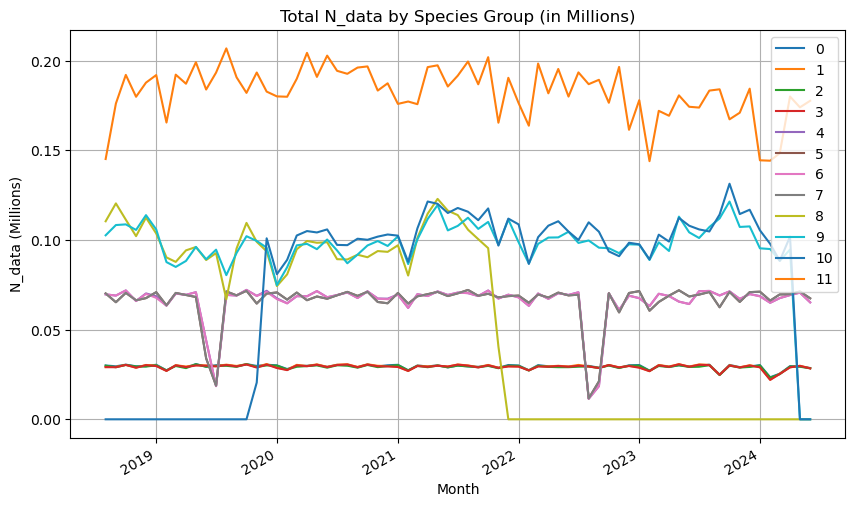

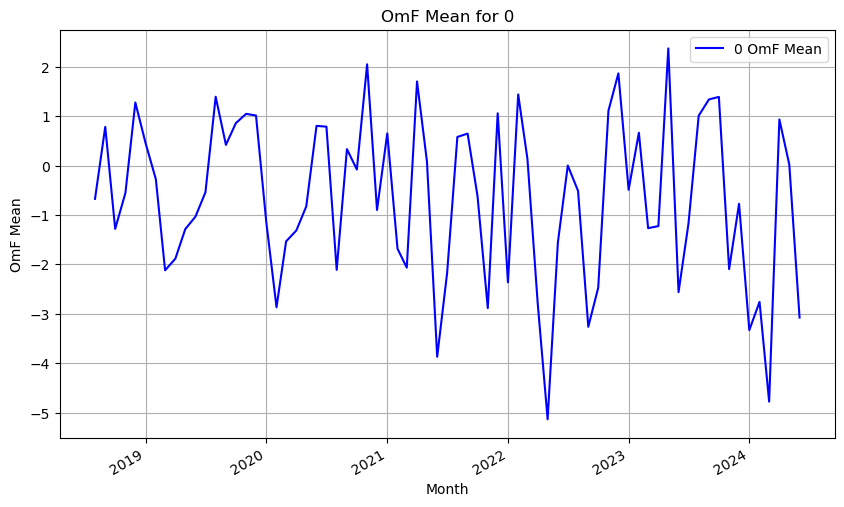

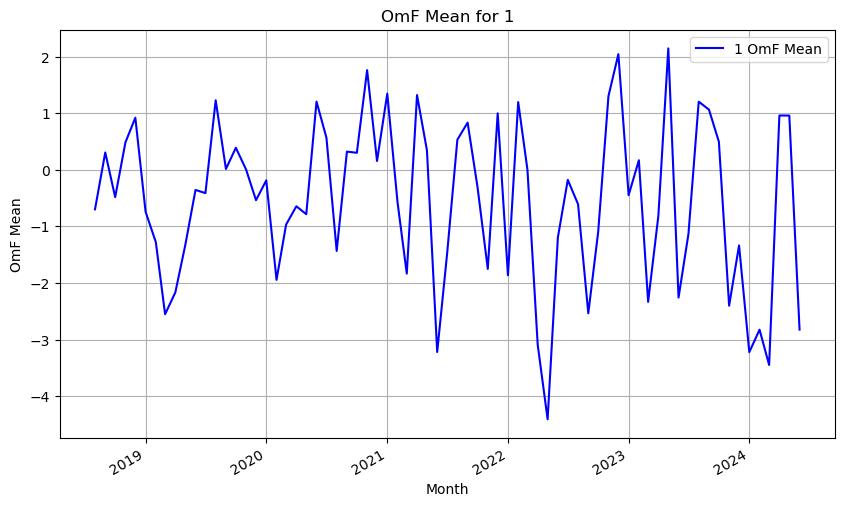

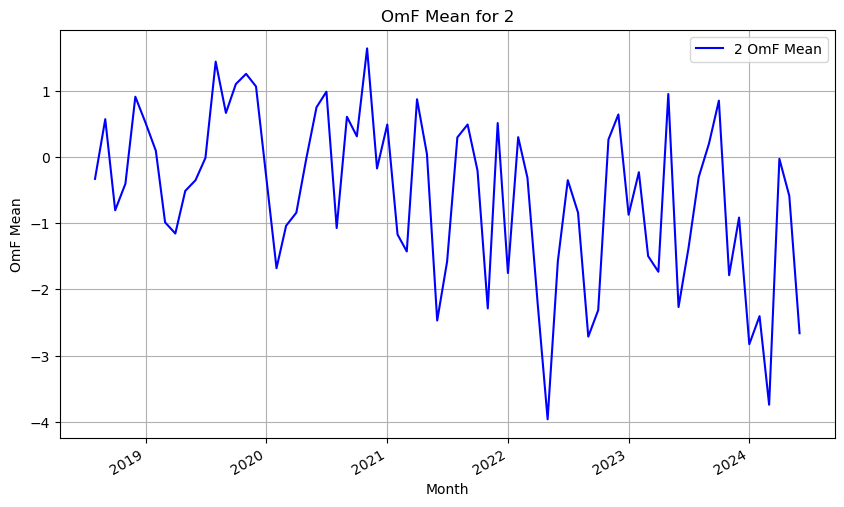

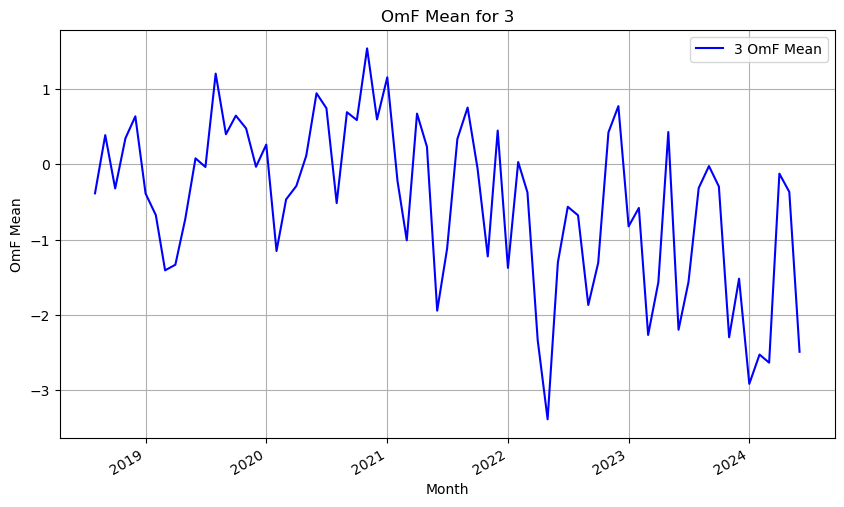

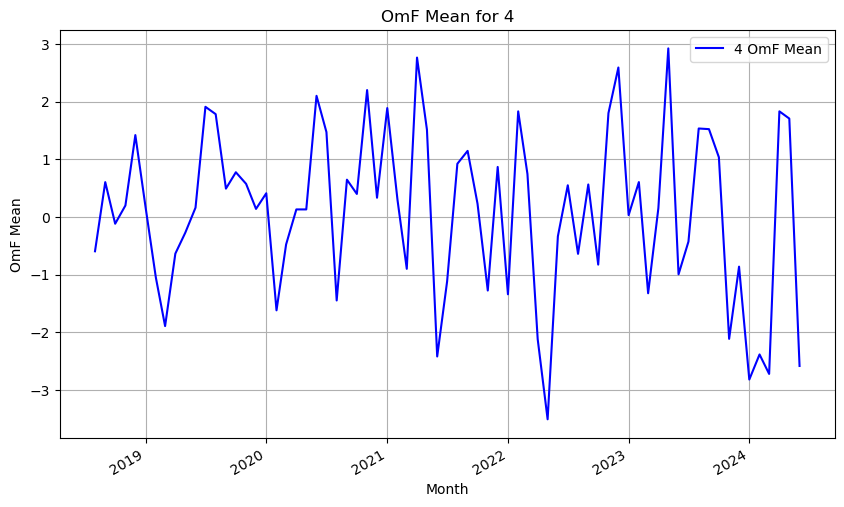

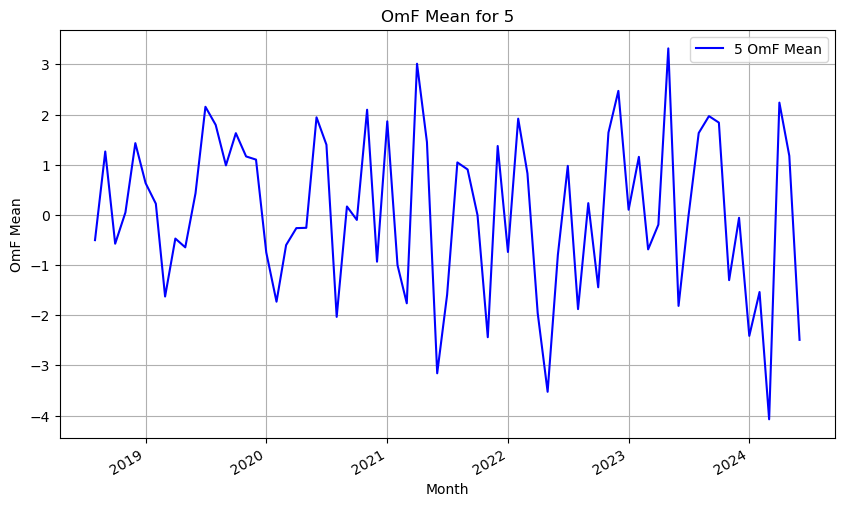

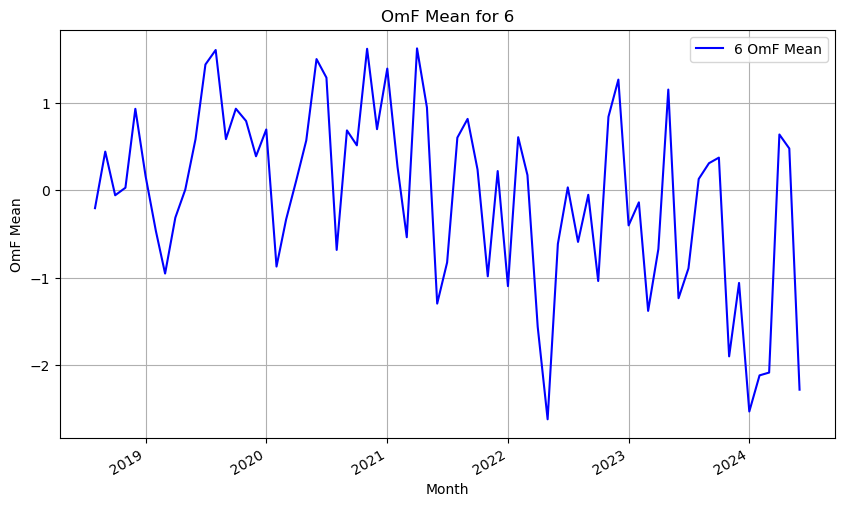

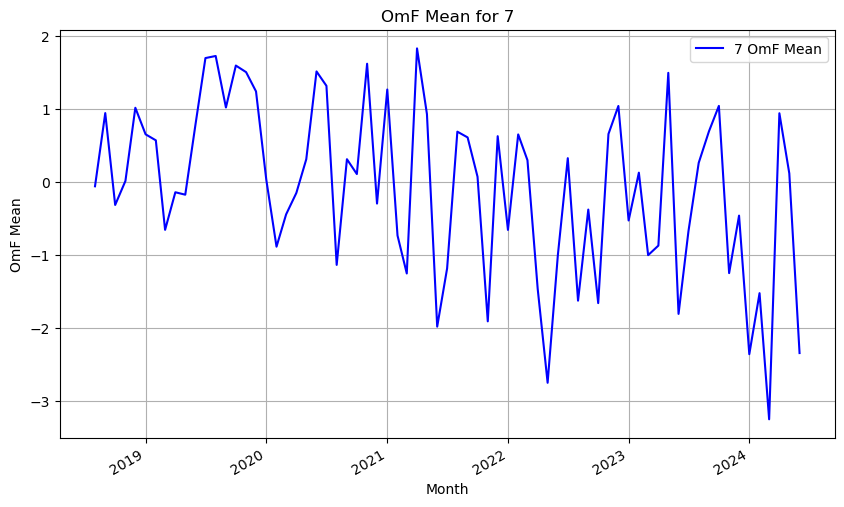

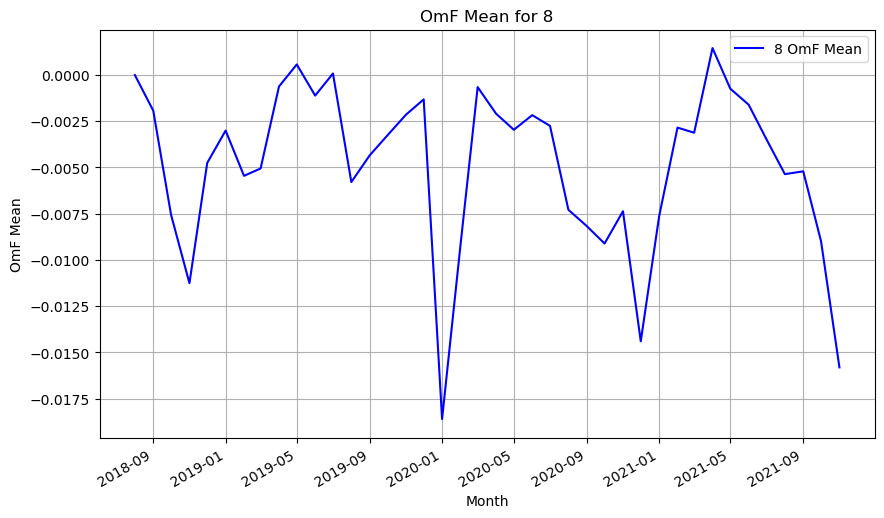

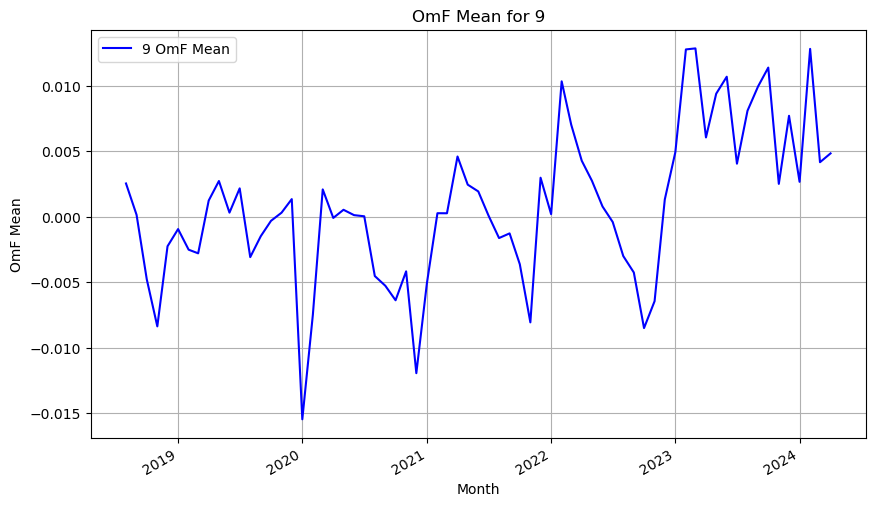

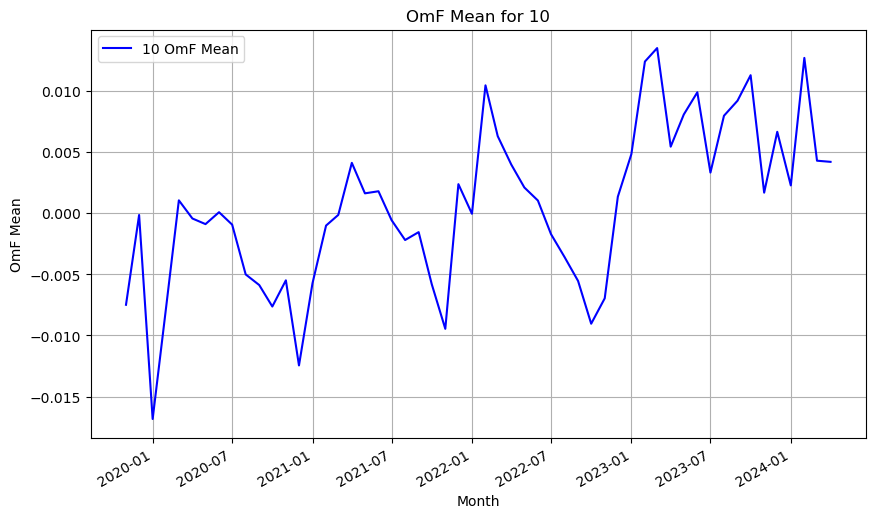

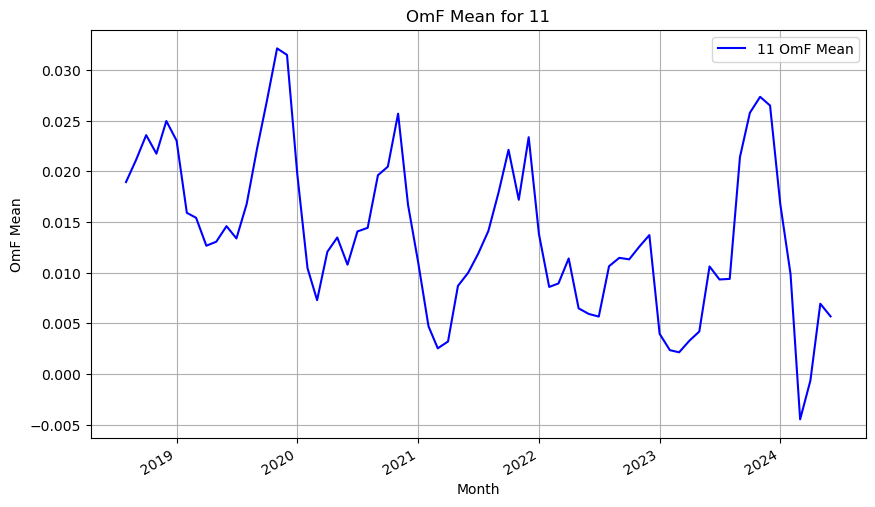

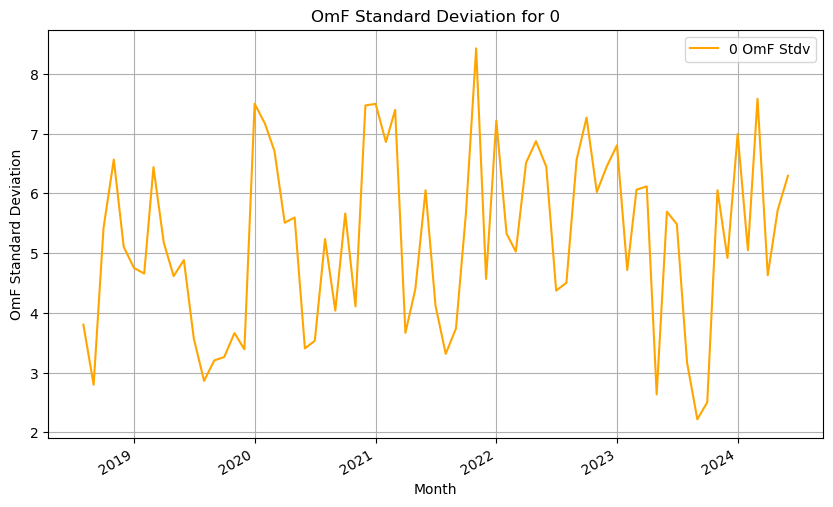

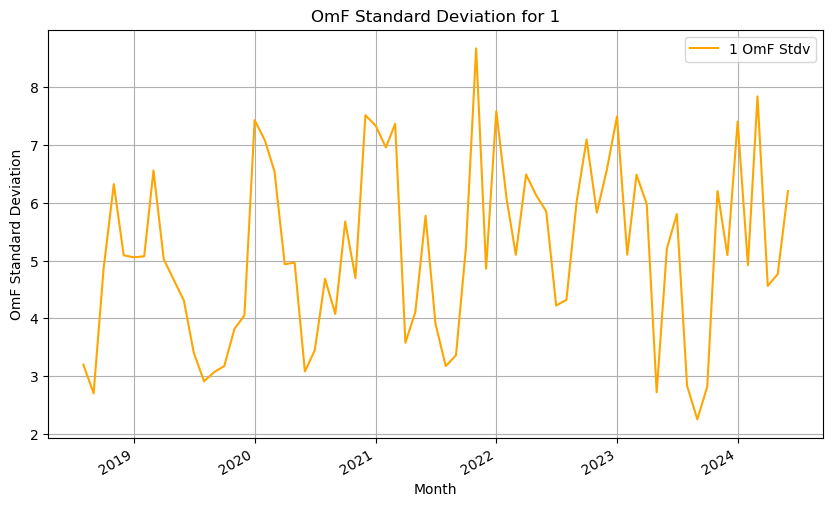

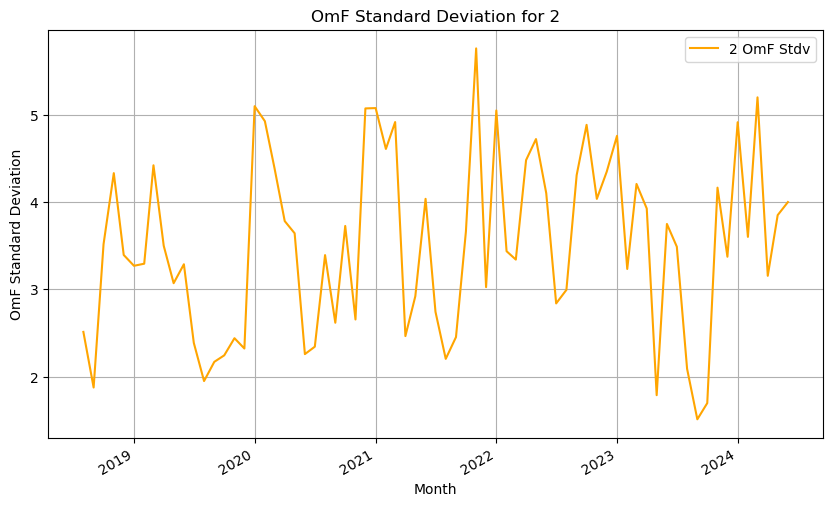

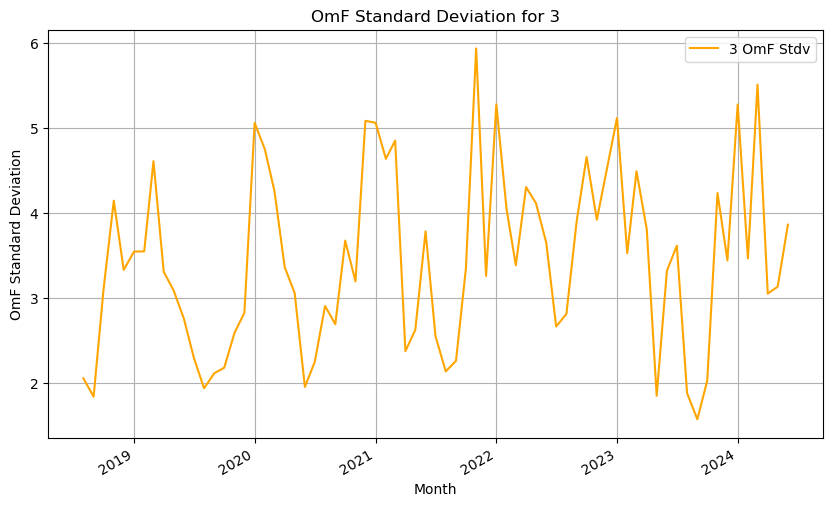

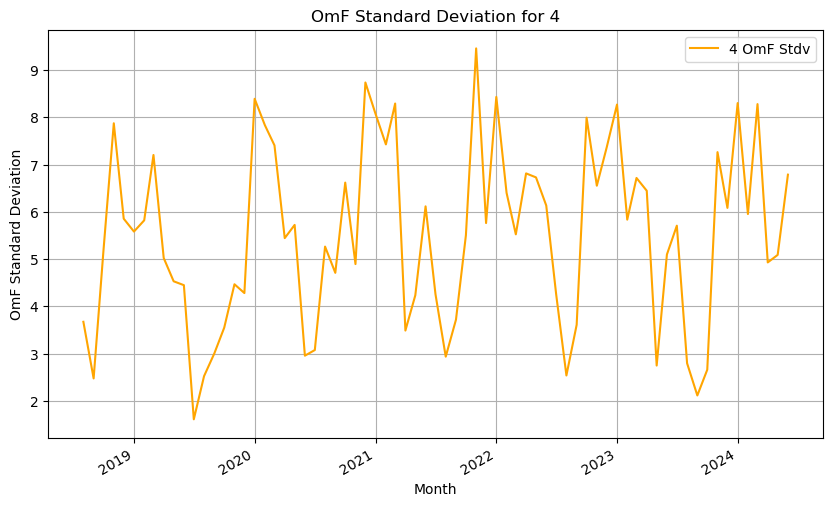

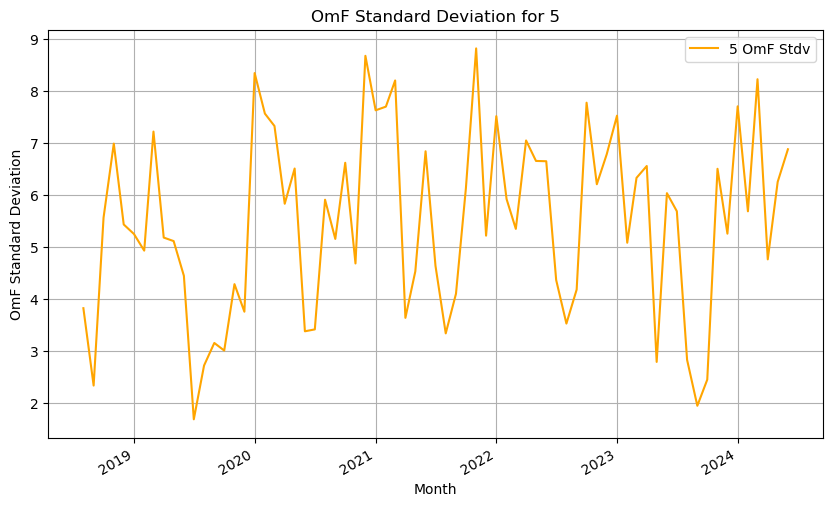

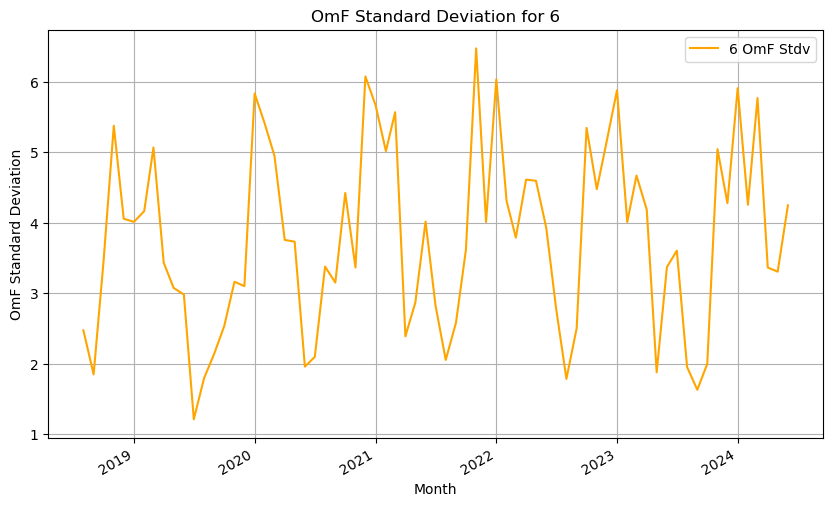

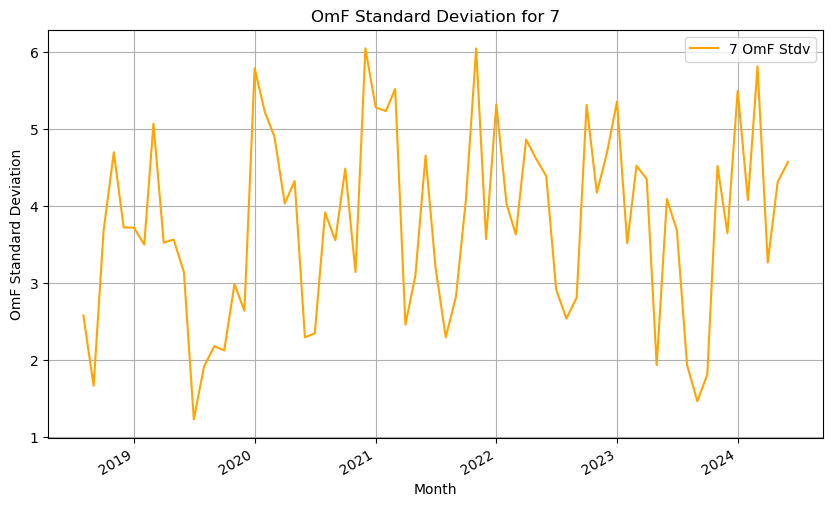

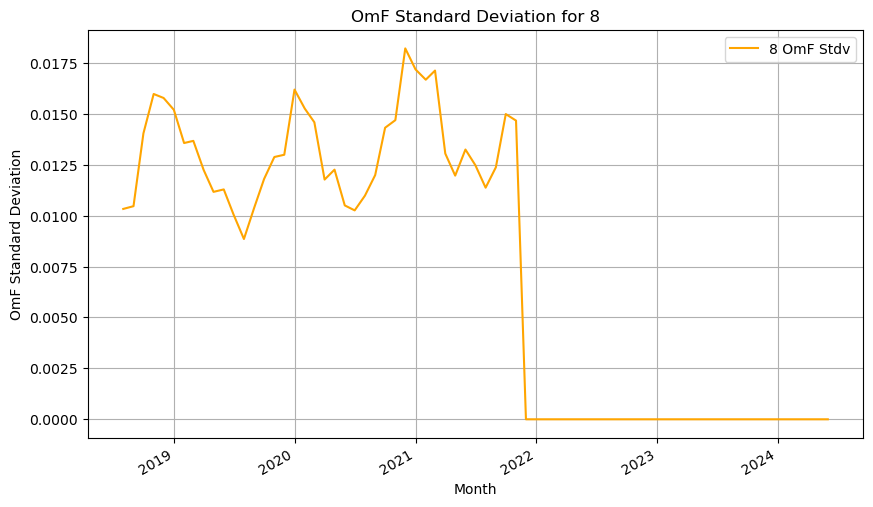

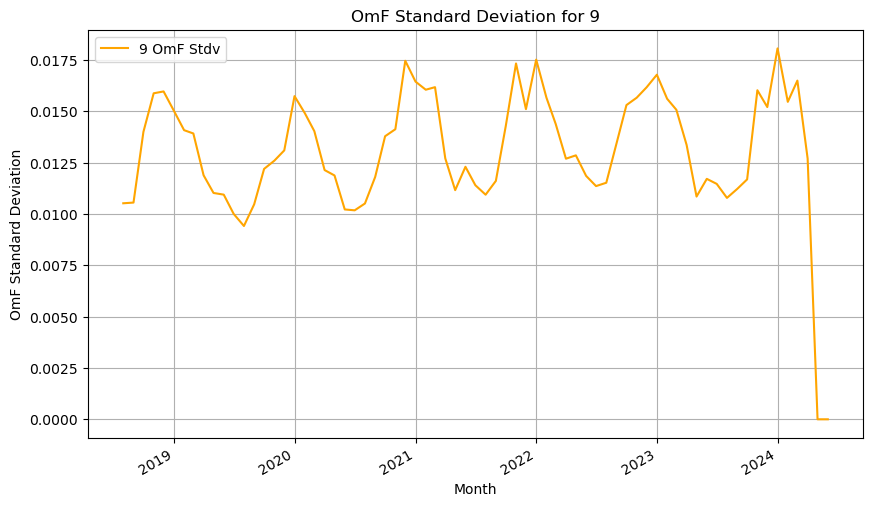

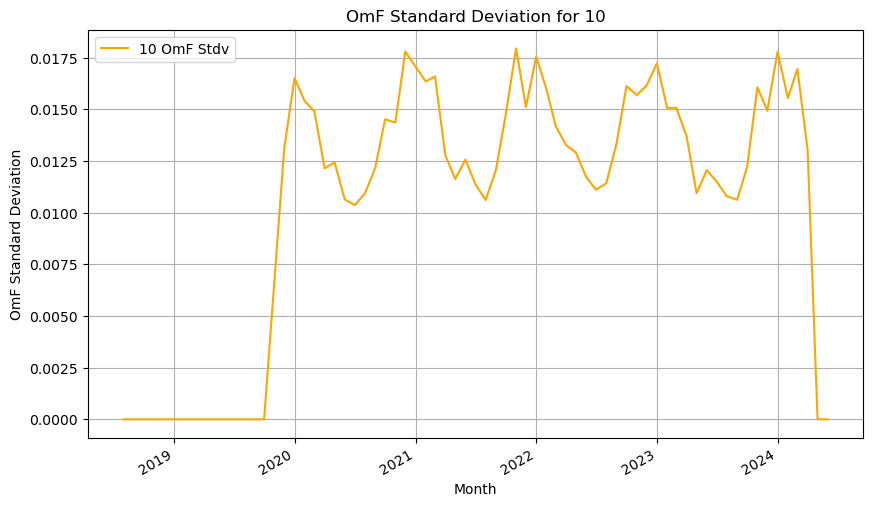

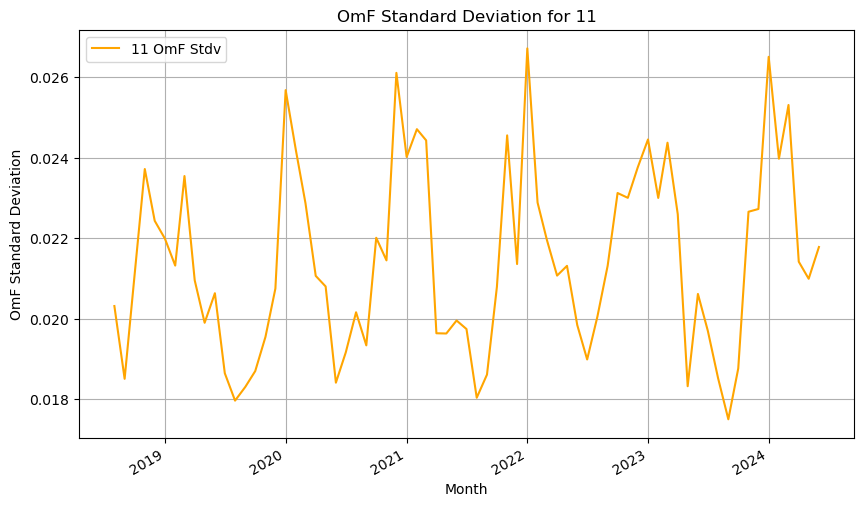

In [9]:
# Plot N_data_group for each species group
plt.figure(figsize=(10, 6))
for group, values in N_data_group_all_months.items():
    values_in_millions = [v / 1e6 for v in values]  # Convert to millions
    plt.plot(monthly_timestamps, values_in_millions, label=group)
    print(f"{group} N_data (in millions): {values_in_millions}")
plt.gcf().autofmt_xdate()
plt.xlabel('Month')
plt.ylabel('N_data (Millions)')
plt.title('Total N_data by Species Group (in Millions)')
plt.legend()
plt.grid()
plt.savefig(out_path + 'N_data_group.png')  # Save the plot for all groups
plt.show()
plt.close()


# Plot OmF_mean for each species group
for group, values in OmF_mean_all_months.items():
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_timestamps, values, label=f'{group} OmF Mean', color='blue')
    plt.gcf().autofmt_xdate()
    plt.xlabel('Month')
    plt.ylabel('OmF Mean')
    plt.title(f'OmF Mean for {group}')
    plt.legend()
    plt.grid()
    plt.savefig(out_path + f'OmF_Mean_{group}.png')  # Save the plot for each group
    plt.show()
    plt.close()


# Plot OmF_stdv for each species group
for group, values in OmF_stdv_all_months.items():
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_timestamps, values, label=f'{group} OmF Stdv', color='orange')
    plt.gcf().autofmt_xdate()
    plt.xlabel('Month')
    plt.ylabel('OmF Standard Deviation')
    plt.title(f'OmF Standard Deviation for {group}')
    plt.legend()
    plt.grid()
    plt.savefig(out_path + f'OmF_Stdv_{group}.png')  # Save the plot for each group
    plt.show()
    plt.close()

71


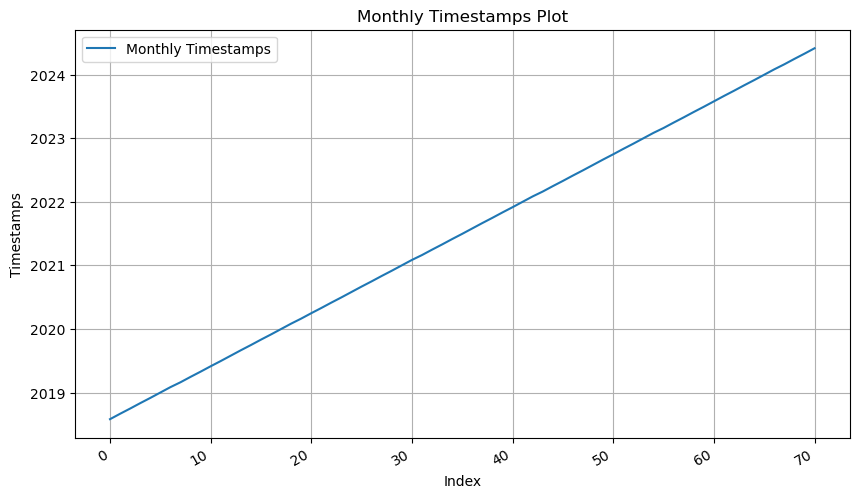

In [10]:
print(len(monthly_timestamps))
plt.figure(figsize=(10, 6))
plt.plot(monthly_timestamps, label='Monthly Timestamps')
plt.gcf().autofmt_xdate()
plt.xlabel('Index')
plt.ylabel('Timestamps')
plt.title('Monthly Timestamps Plot')
plt.legend()
plt.grid()
plt.show()

Mean of grid_data: 1321.0155604953954
Min of grid_data: 0.0
Max of grid_data: 1887.0
Mean of grid_data: -0.5391378807272575
Min of grid_data: -12.59845814195028
Max of grid_data: 26.751800044890388
Mean of grid_data: 7.789588305978355
Min of grid_data: 2.118838642862531
Max of grid_data: 23.176561395644065
Mean of grid_data: 0.07106988994399024
Min of grid_data: -0.2874982529867748
Max of grid_data: 0.5759861893073469


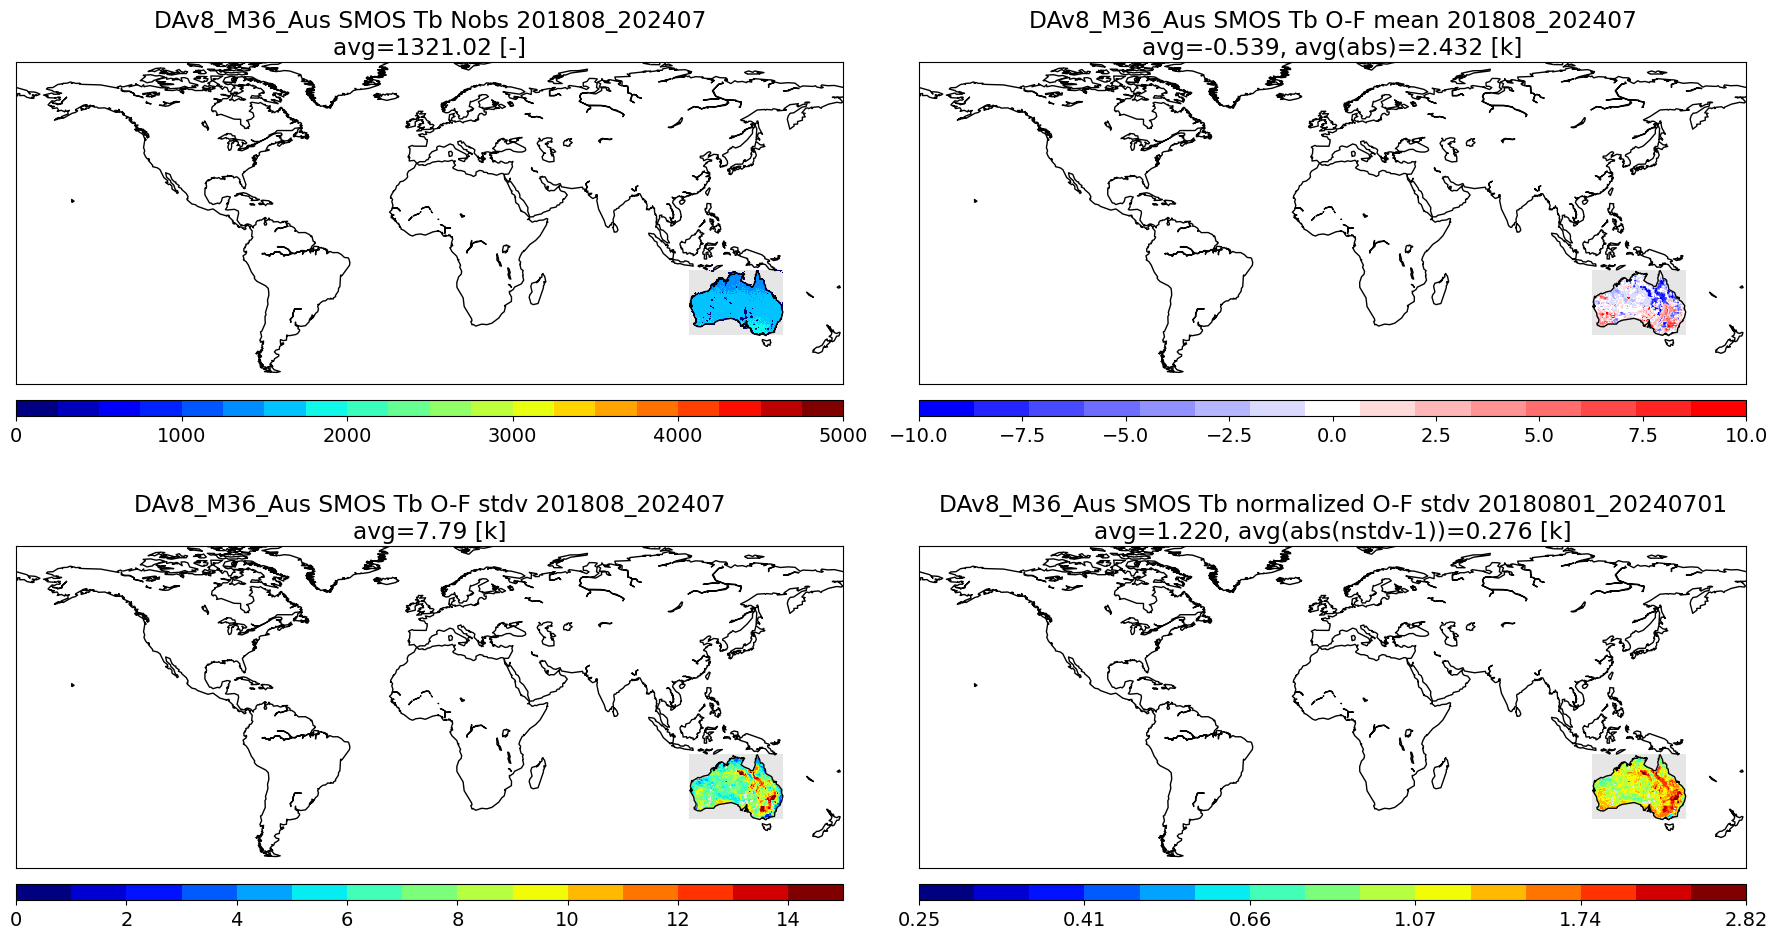

In [11]:
#loaded_group_metrics = group_metrics


fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['SMOS']['Nobs_data']
OmF_mean = loaded_group_metrics['SMOS']['OmF_mean']
OmF_stdv = loaded_group_metrics['SMOS']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['SMOS']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['SMOS']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[k]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 5000] # np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' SMOS Tb Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-10, 10]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' SMOS Tb O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMOS Tb O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMOS Tb normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))
    
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])            

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_SMOS_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

Mean of grid_data: 2976.3910765322325
Min of grid_data: 0.0
Max of grid_data: 4094.0
Mean of grid_data: 0.0016510179307283159
Min of grid_data: -11.504747508027421
Max of grid_data: 27.284993090178798
Mean of grid_data: 7.741438805435834
Min of grid_data: 1.671082372353756
Max of grid_data: 26.474620543207735
Mean of grid_data: 0.06813857110349546
Min of grid_data: -0.39082195791428614
Max of grid_data: 0.633541701925437


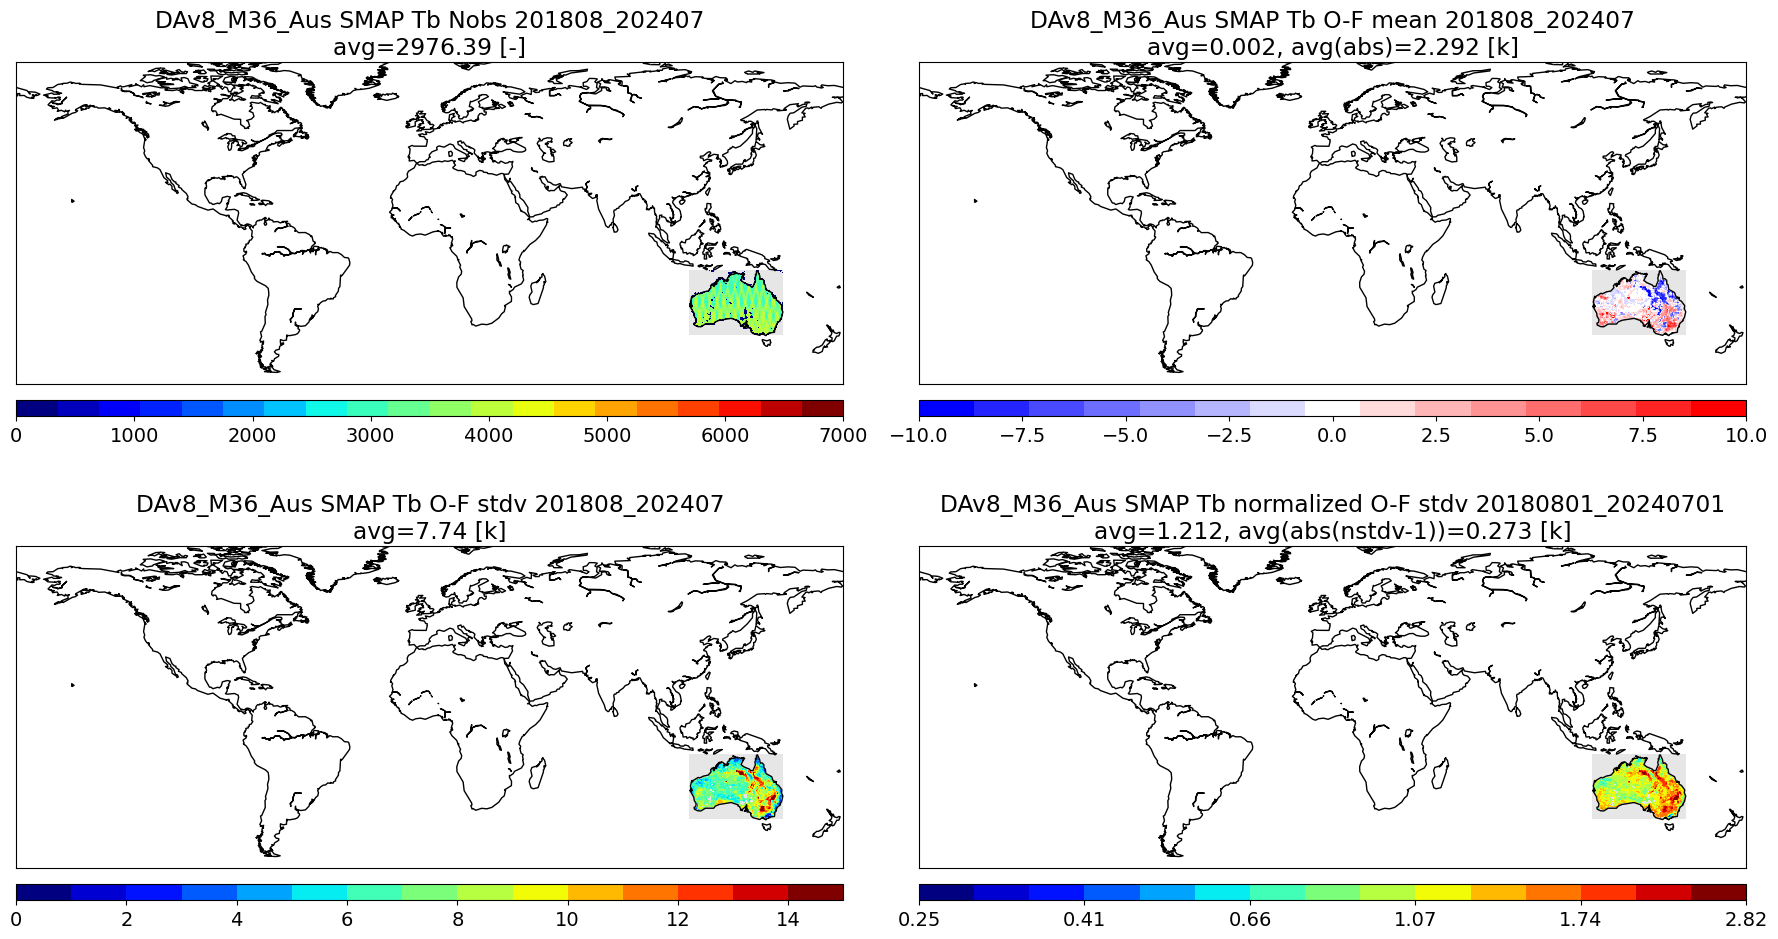

In [12]:
# Plotting
fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['SMAP']['Nobs_data']
OmF_mean = loaded_group_metrics['SMAP']['OmF_mean']
OmF_stdv = loaded_group_metrics['SMAP']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['SMAP']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['SMAP']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[k]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 7000] #np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' SMAP Tb Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-10, 10]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' SMAP Tb O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMAP Tb O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMAP Tb normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))            
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])            

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_SMAP_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

Mean of grid_data: 2579.316608447126
Min of grid_data: 0.0
Max of grid_data: 5746.0
Mean of grid_data: -0.00047731046032239955
Min of grid_data: -0.14120482600127496
Max of grid_data: 0.07563633674277795
Mean of grid_data: 0.023266416858952865
Min of grid_data: 0.0
Max of grid_data: 0.061424837002165326
Mean of grid_data: -inf
Min of grid_data: -inf
Max of grid_data: 0.22628977601866795


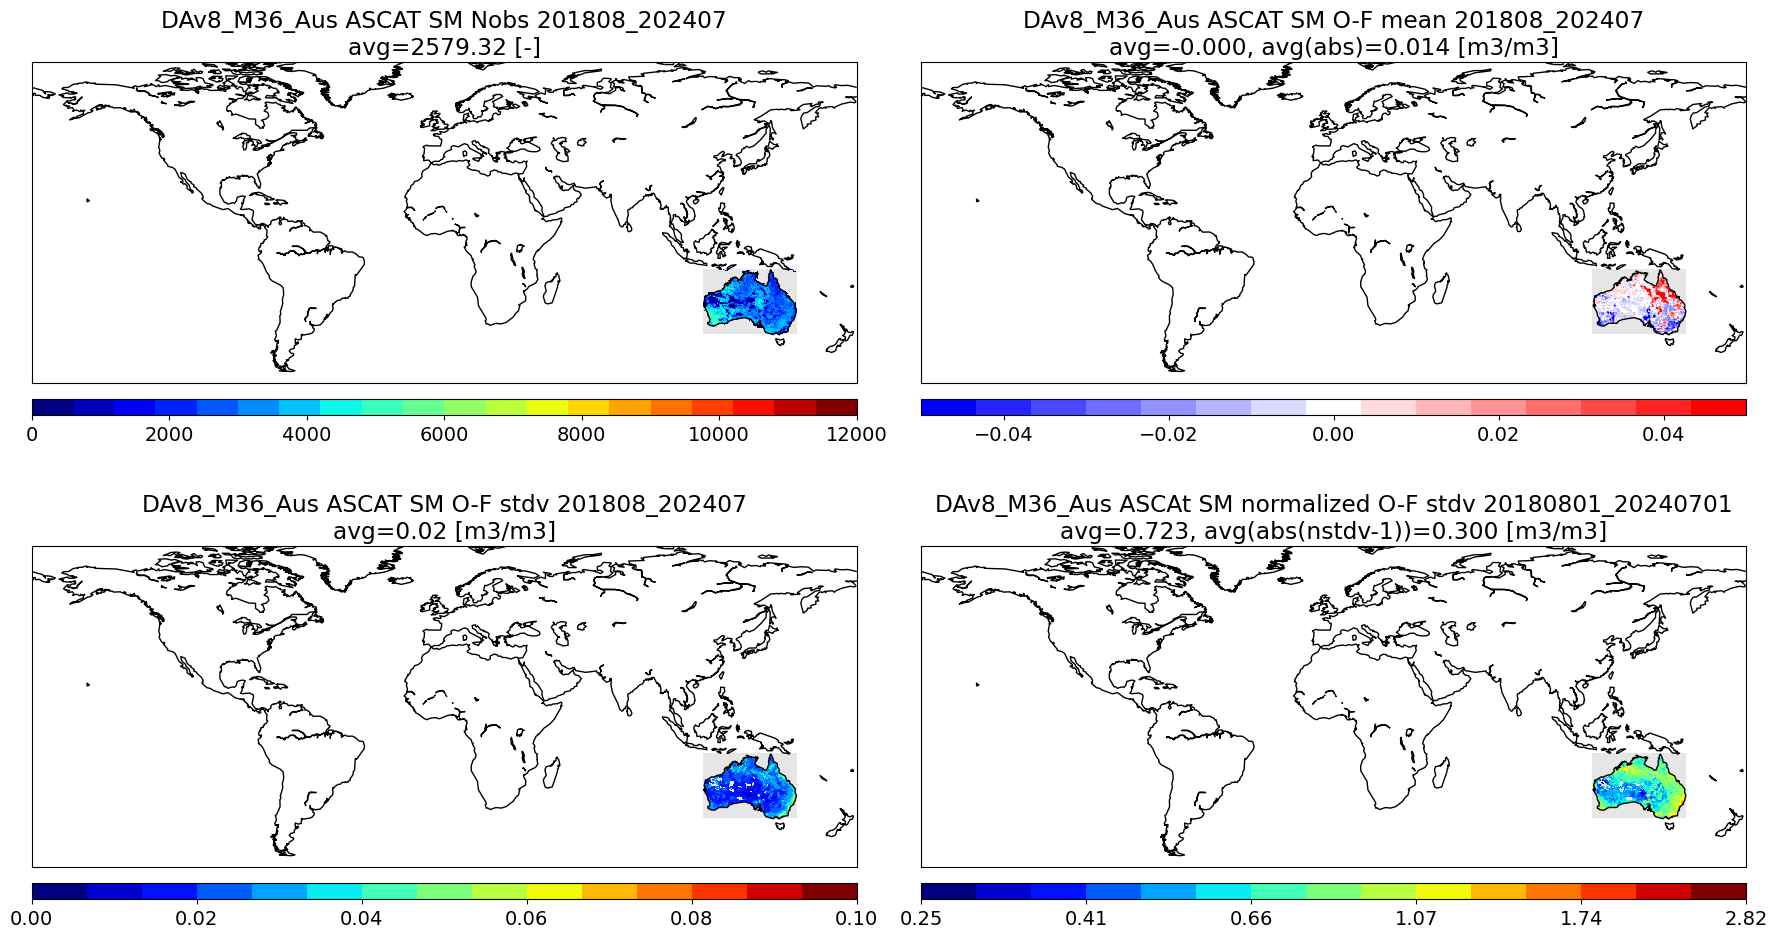

In [13]:
# Plotting
fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['ASCAT']['Nobs_data']
OmF_mean = loaded_group_metrics['ASCAT']['OmF_mean']
OmF_stdv = loaded_group_metrics['ASCAT']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['ASCAT']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['ASCAT']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[m3/m3]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 12000] #np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' ASCAT SM Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-0.05, 0.05]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' ASCAT SM O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 0.1]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' ASCAT SM O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' ASCAt SM normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))                
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])            

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_ASCAT_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

KeyError: 'MODIS'

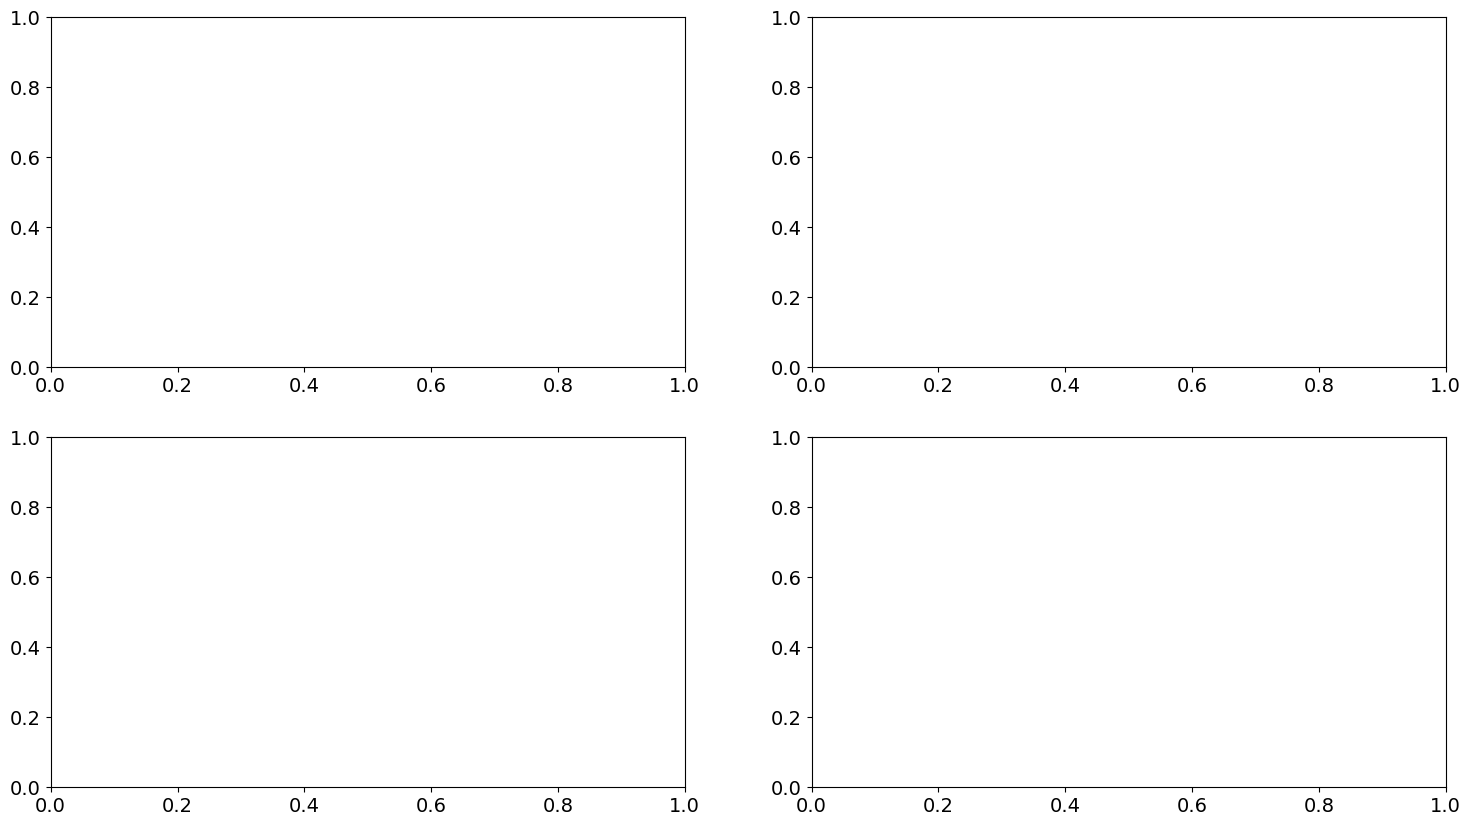

In [14]:
# Plotting
fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['MODIS']['Nobs_data']
OmF_mean = loaded_group_metrics['MODIS']['OmF_mean']
OmF_stdv = loaded_group_metrics['MODIS']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['MODIS']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['MODIS']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[frac.]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 20000] #np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' SCF Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-1, 1]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' SCF O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 0.5]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SCF O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SCF normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])    

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))                  

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_SCF_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

Mean of grid_data: 2055.9563353445537
Min of grid_data: 0.0
Max of grid_data: 2959.0
Mean of grid_data: 0.01425474741689252
Min of grid_data: -0.11274619303319763
Max of grid_data: 0.25308994750000224
Mean of grid_data: 0.02992372696259772
Min of grid_data: 0.0
Max of grid_data: 0.10969035049170829
Mean of grid_data: -inf
Min of grid_data: -inf
Max of grid_data: 0.3921461659403714


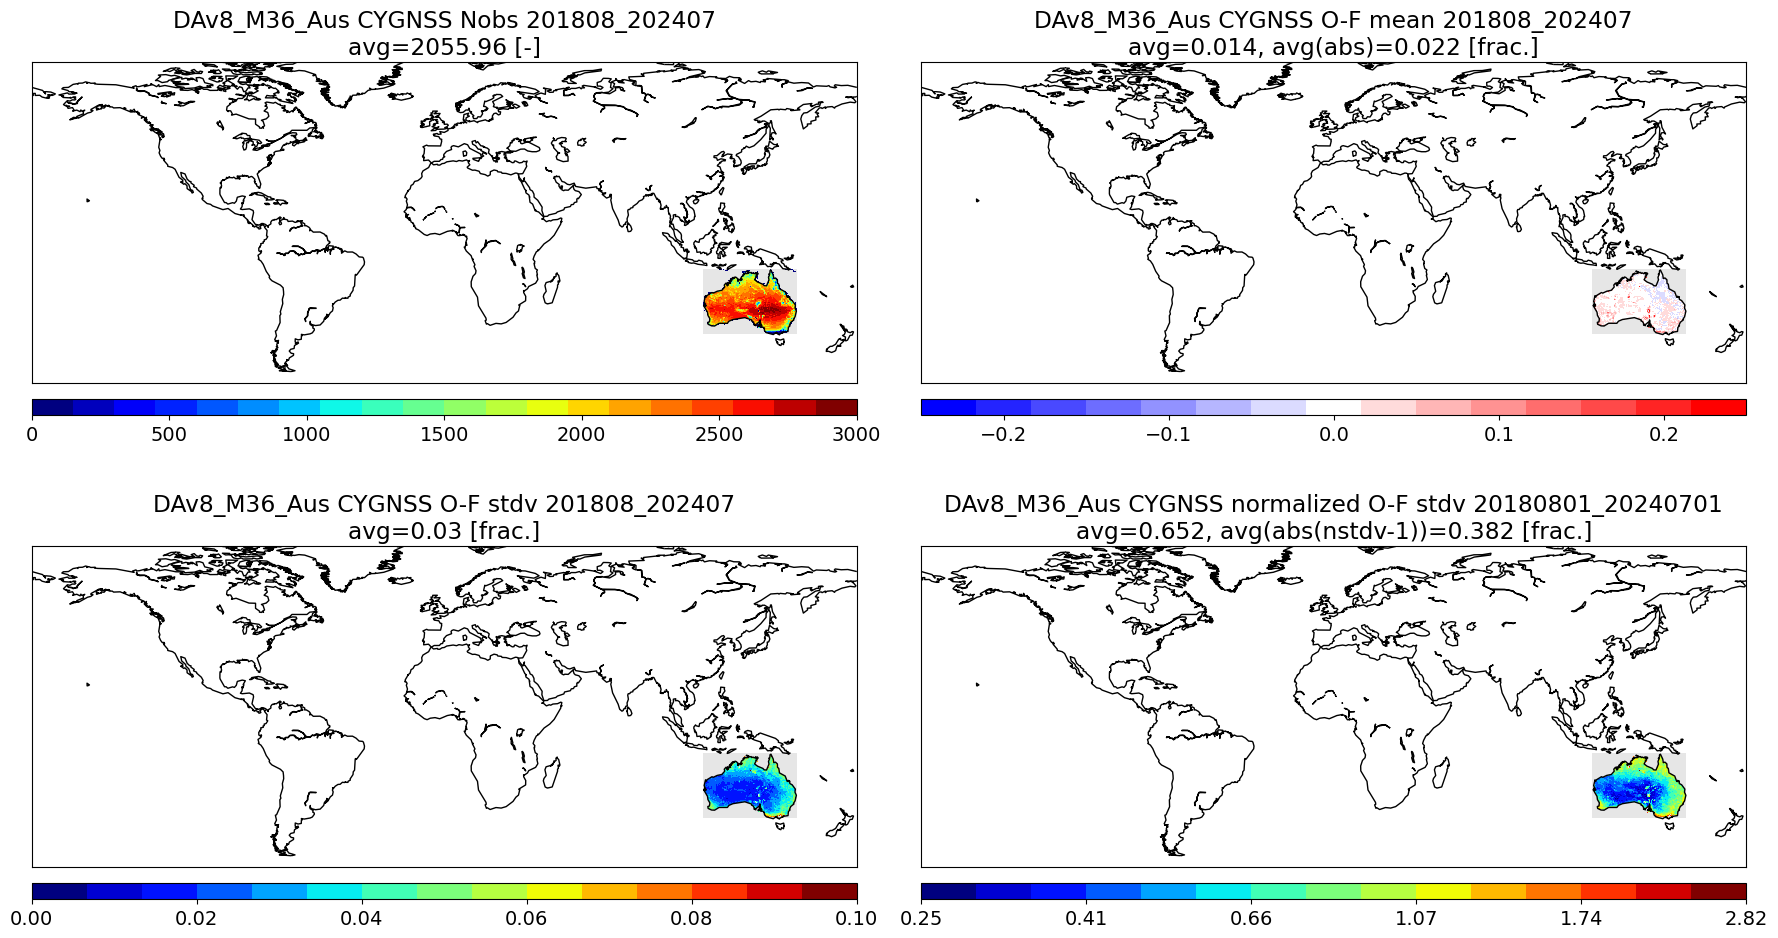

In [15]:
# Plotting
fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['CYGNSS']['Nobs_data']
OmF_mean = loaded_group_metrics['CYGNSS']['OmF_mean']
OmF_stdv = loaded_group_metrics['CYGNSS']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['CYGNSS']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['CYGNSS']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[frac.]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 3000] #np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' CYGNSS Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-0.25, 0.25]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' CYGNSS O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 0.1]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' CYGNSS O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' CYGNSS normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])    

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))                  

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_SCF_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

In [16]:
# Load the lists of monthly data from the file
expdir ='/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_Aus/' 
expid = 'DAv8_M36_Aus'
out_path = expdir+expid+'/output/'+domain+'/figures/'

with open(out_path + f'monthly_OmF_data_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'rb') as f:
    monthly_data_da = pickle.load(f)

with open(out_path + f'group_metrics_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'rb') as f:
    group_metrics_da = pickle.load(f)   

monthly_timestamps_da = monthly_data_da['monthly_timestamps']    

expdir ='/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/OLv8_M36_Aus/' 
expid = 'OLv8_M36_Aus'
out_path = expdir+expid+'/output/'+domain+'/figures/'
# Load the lists of monthly data from the file
with open(out_path + f'monthly_OmF_data_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'rb') as f:
    monthly_data_ol = pickle.load(f)

with open(out_path + f'group_metrics_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'rb') as f:
    group_metrics_ol = pickle.load(f)

monthly_timestamps_ol = monthly_data_ol['monthly_timestamps']    



0 OmF StdDev: [3.7412528744015745, 2.74149558838111, 5.483442728272101, 6.756201385946679, 5.265676790720746, 4.843785651016014, 4.899425156223737, 6.627175874462686, 5.383645127230142, 4.759640116038734, 4.957157824485337, 3.6776628610130864, 2.786443190162781, 3.1540368731301984, 3.2327013961722186, 3.686748573547388, 3.4160690727723972, 7.659928323259779, 7.1876824455206165, 7.005815404873854, 5.634242628878205, 5.913599971538039, 3.4276350077171993, 3.5510128166546955, 5.477513684492225, 4.205218089185114, 5.959228406093624, 4.241316284901786, 7.643966185121356, 7.740235675097705, 7.046741744519099, 7.605099247770365, 3.856231432358131, 4.386606807386462, 6.331049344898099, 4.185074080827114, 3.418225228867495, 3.878890933528893, 5.762224992179039, 8.640647637029351, 4.73949169764483, 7.259278585443367, 5.508837128800048, 5.138640600852328, 6.782858886202919, 7.0764917120495205, 6.662705313805862, 4.700168002878811, 4.62035423893313, 6.720064147927189, 7.503555813273381, 6.19020282

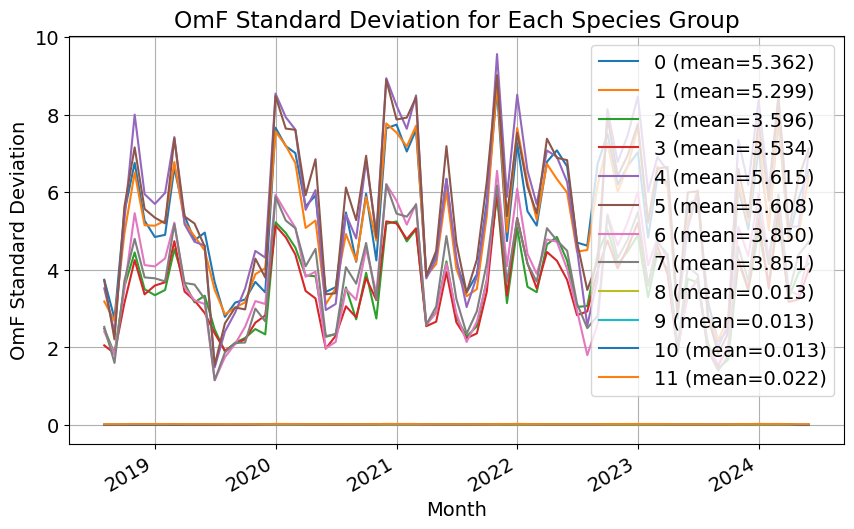

In [17]:
# Plot OmF_stdv for each species group in monthly_data_da
plt.figure(figsize=(10, 6))
for group, values in monthly_data_ol['OmF_stdv_all_months'].items():
    mean_value = np.nanmean([v for v in values if v != 0])
    plt.plot(monthly_timestamps_da, values, label=f'{group} (mean={mean_value:.3f})')
    print(f"{group} OmF StdDev: {values}")
plt.gcf().autofmt_xdate()
plt.xlabel('Month')
plt.ylabel('OmF Standard Deviation')
plt.title('OmF Standard Deviation for Each Species Group')
plt.legend()
plt.grid()
plt.show()

In [18]:
def group_species_data(monthly_data, species_groups):
    # Initialize grouped data dictionaries
    N_data_grouped = {group: [] for group in species_groups.keys()}
    OmF_mean_grouped = {group: [] for group in species_groups.keys()}
    OmF_stdv_grouped = {group: [] for group in species_groups.keys()}
    
    # For each month
    for month_idx in range(len(monthly_data['monthly_timestamps'])):
        # Process each group
        for group_name, species_indices in species_groups.items():
            # Sum N_data across species in group
            N_data_sum = sum(monthly_data['N_data_group_all_months'][species][month_idx] 
                           for species in species_indices)
            
            # Calculate weighted means for OmF metrics
            OmF_mean_weights = [monthly_data['N_data_group_all_months'][species][month_idx] 
                              for species in species_indices]
            OmF_mean_values = [monthly_data['OmF_mean_all_months'][species][month_idx] 
                             for species in species_indices]
            OmF_stdv_values = [monthly_data['OmF_stdv_all_months'][species][month_idx] 
                             for species in species_indices]
            
            # Calculate weighted means, handling zero weights
            if sum(OmF_mean_weights) > 0:
                weighted_OmF_mean = np.average(OmF_mean_values, weights=OmF_mean_weights)
                weighted_OmF_stdv = np.average(OmF_stdv_values, weights=OmF_mean_weights)
            else:
                weighted_OmF_mean = np.nan
                weighted_OmF_stdv = np.nan
            
            # Store results
            N_data_grouped[group_name].append(N_data_sum)
            OmF_mean_grouped[group_name].append(weighted_OmF_mean)
            OmF_stdv_grouped[group_name].append(weighted_OmF_stdv)
    
    return {
        'N_data_group_all_months': N_data_grouped,
        'OmF_mean_all_months': OmF_mean_grouped,
        'OmF_stdv_all_months': OmF_stdv_grouped,
        'monthly_timestamps': monthly_data['monthly_timestamps']
    }


In [19]:
# Usage
grouped_data_da = group_species_data(monthly_data_da, species_groups)
grouped_data_ol = group_species_data(monthly_data_ol, species_groups)

# Now you can use the grouped data with your existing plotting code
N_data_group_all_months_da = grouped_data_da['N_data_group_all_months']
N_data_group_all_months_ol = grouped_data_ol['N_data_group_all_months']
OmF_mean_all_months_da = grouped_data_da['OmF_mean_all_months']
OmF_mean_all_months_ol = grouped_data_ol['OmF_mean_all_months']
OmF_stdv_all_months_da = grouped_data_da['OmF_stdv_all_months']
OmF_stdv_all_months_ol = grouped_data_ol['OmF_stdv_all_months']
monthly_timestamps_da = grouped_data_da['monthly_timestamps']
monthly_timestamps_ol = grouped_data_ol['monthly_timestamps']

# Replace 0 with NaN in the data
for group, values in OmF_mean_all_months_da.items():
    OmF_mean_all_months_da[group] = [np.nan if v == 0 else v for v in values]

for group, values in OmF_stdv_all_months_da.items():
    OmF_stdv_all_months_da[group] = [np.nan if v == 0 else v for v in values]

for group, values in OmF_mean_all_months_ol.items():
    OmF_mean_all_months_ol[group] = [np.nan if v == 0 else v for v in values]

for group, values in OmF_stdv_all_months_ol.items():
    OmF_stdv_all_months_ol[group] = [np.nan if v == 0 else v for v in values]


SMOS DA N_data (in millions): [0.118176, 0.116944, 0.121554, 0.116632, 0.119577, 0.120266, 0.108643, 0.120085, 0.11609, 0.121801, 0.118591, 0.119226, 0.120819, 0.118103, 0.122848, 0.117092, 0.121898, 0.117447, 0.110929, 0.119579, 0.118913, 0.121532, 0.116434, 0.121235, 0.121391, 0.116172, 0.122078, 0.118007, 0.119071, 0.119268, 0.10862, 0.119472, 0.11731, 0.119941, 0.116846, 0.121007, 0.119026, 0.116384, 0.120265, 0.114687, 0.11931, 0.11877, 0.109212, 0.119273, 0.117698, 0.117889, 0.117203, 0.119305, 0.118298, 0.114745, 0.120745, 0.115286, 0.119554, 0.11804, 0.107951, 0.120289, 0.117182, 0.121733, 0.117418, 0.120085, 0.121263, 0.099291, 0.120467, 0.115904, 0.118881, 0.118338, 0.090739, 0.101409, 0.117121, 0.118463, 0.113935]
SMAP DA N_data (in millions): [0.279862, 0.268698, 0.284894, 0.264798, 0.275386, 0.278293, 0.253965, 0.281319, 0.277599, 0.278243, 0.155974, 0.074557, 0.281513, 0.276402, 0.287749, 0.266848, 0.283048, 0.276031, 0.262968, 0.278809, 0.270128, 0.280087, 0.270702, 0.27

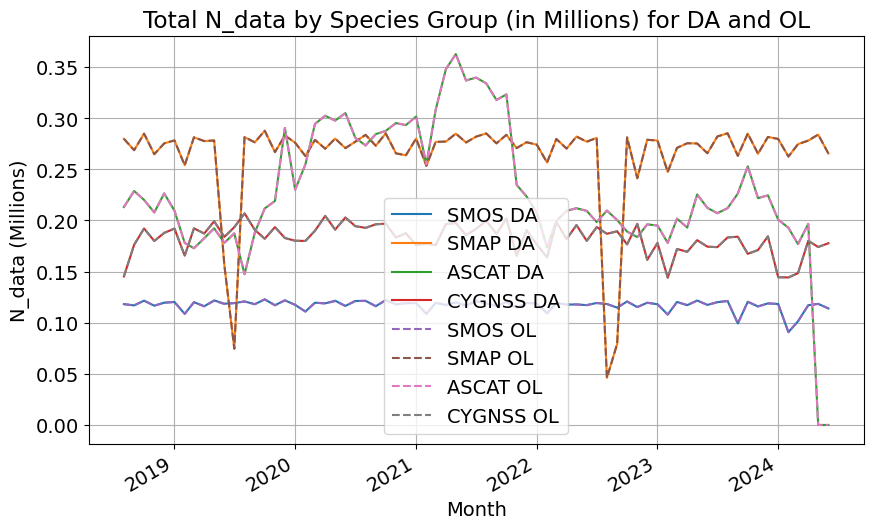

SMOS DA OmF Mean: [-0.5203956064428636, 0.5149569621441353, -0.7217798819253199, -0.03560990623039127, 0.9369067233406664, -0.035952412604632195, -0.5305145417494708, -1.7689633952130497, -1.6373580236128675, -0.9631293222142491, -0.4107018168880104, -0.25046887760771513, 1.318403161149706, 0.37514452508106055, 0.7515374879839855, 0.7004624075214465, 0.3733233684629292, -0.3501760893461632, -1.914806467104511, -0.9991648046948565, -0.7714448101051876, -0.38045032163720754, 0.9284533271146796, 0.7728747091098872, -1.2806441575519587, 0.4897893338224464, 0.2815103561368066, 1.7502507169637993, -0.08253520782211106, 0.9068762571430883, -0.914272240985954, -1.5847750362384452, 1.1462184318309425, 0.17781074616063458, -2.8733271255500883, -1.5856928055811863, 0.43761403396898557, 0.6832855725898225, -0.2950920886633482, -2.0357551964971248, 0.7575746689611124, -1.8405235870938361, 0.7449618383889968, -0.13580978808277788, -2.609175861994607, -4.221321120039524, -1.4059965470048632, -0.27107

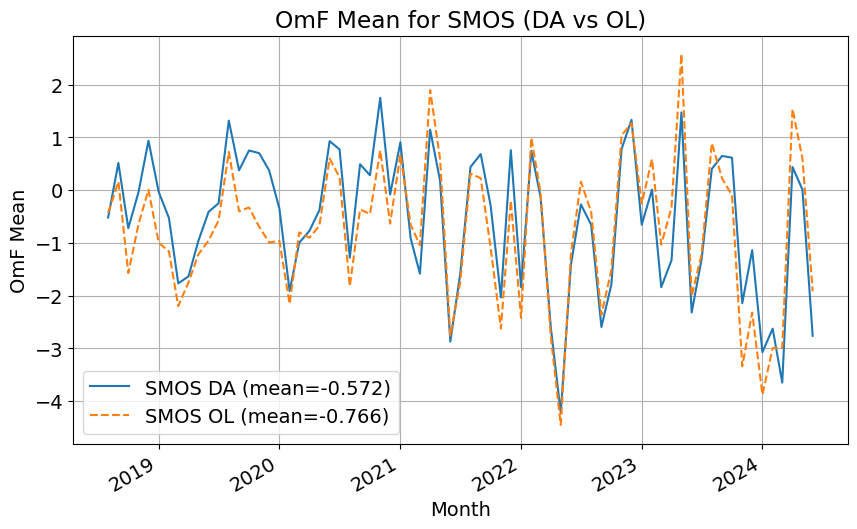

SMAP DA OmF Mean: [-0.34132873416538634, 0.8046877031251854, -0.26523565707667324, 0.0716291016113522, 1.1987152634981681, 0.40768287122426033, -0.18006554308902545, -1.2827211948338852, -0.39135292790269904, -0.27014056722366536, 0.47553475853071575, 1.8004836139952431, 1.7268118798616234, 0.7703856293892548, 1.2309186925409874, 0.9978888594282266, 0.71266637334152, 0.0850692763770652, -1.2788895859171976, -0.46623798417346324, -0.03986906033086455, 0.1913814858388232, 1.7649395949347682, 1.3682933551552954, -1.3266125997795226, 0.4500807789647978, 0.2298453802447076, 1.8836879405317728, -0.03964077213050798, 1.6020597094855695, -0.30532822652757385, -1.110722674457443, 2.307890397832169, 1.209457872282077, -2.2133325558278942, -1.180166021172324, 0.8147264703771677, 0.8687817496654553, 0.13322586528738453, -1.6555051214835603, 0.7698579951793855, -0.9576580855084565, 1.2516891209782062, 0.509337578639195, -1.7774839059437246, -3.10309868989924, -0.6871732296555167, 0.4690991677222031

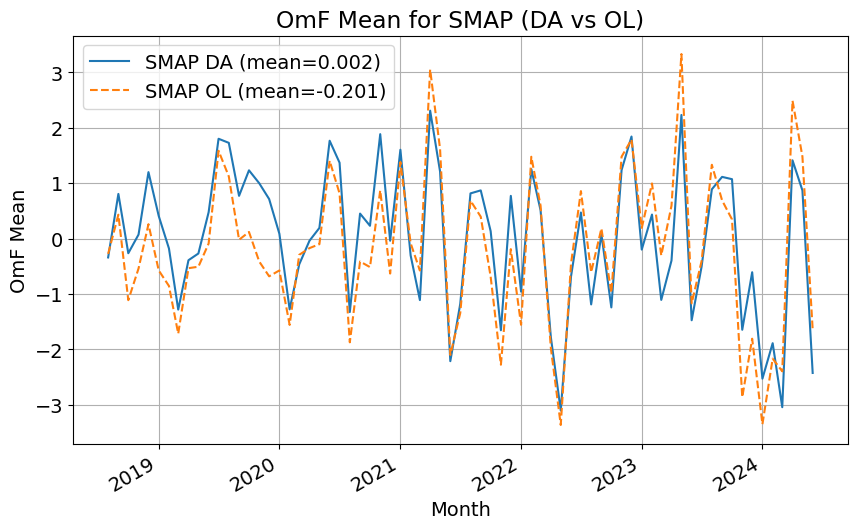

ASCAT DA OmF Mean: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.0015324195303992726, -3.754551122869904e-05, -0.016950197338562078, -0.008086879588396457, 0.0008378774197868047, -0.0008713117880957962, -0.0011273207159613018, -0.0006388895664587302, -0.0011916438427289808, -0.005599179136869492, -0.006421623635899476, -0.007673371870682115, -0.005641502361337303, -0.012898561734961641, -0.006124875018808757, -0.0011573163843945481, -0.0009913186491281132, 0.003387364905297965, 0.0010889970479673195, 0.0006563518488814655, -0.0013372096173665364, -0.0030078715251282933, -0.002615932573333406, -0.006003634614300433, -0.009973198031891662, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], Mean: -0.004
ASCAT OL OmF Mean: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.007163693802880306, 0.008033473955161024, -0.0107094714

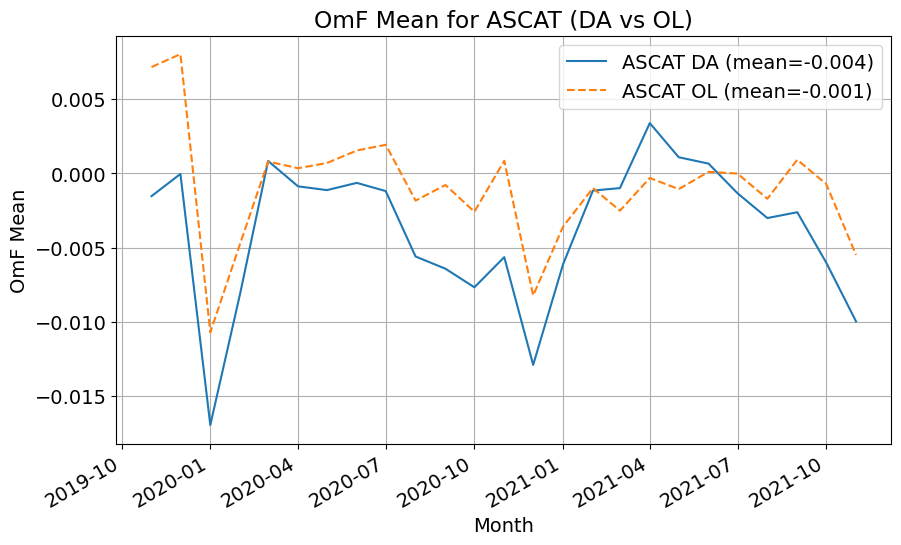

CYGNSS DA OmF Mean: [0.018947315113829428, 0.021177234162365347, 0.023582584819511383, 0.021751113638965404, 0.024974040636431664, 0.02303985986911466, 0.01591481694543383, 0.015424220558788072, 0.012669278610565007, 0.0130639368151919, 0.014598142169733076, 0.01338689186287695, 0.01678999502515817, 0.022179444948964386, 0.026936929148389258, 0.03213898864122504, 0.031492566264553, 0.019751394764804333, 0.010458550202362553, 0.007297973533857736, 0.012067896008465789, 0.013480619658491557, 0.010798483296704416, 0.01407691900613309, 0.0144351293572809, 0.01962405846471076, 0.02047110321891997, 0.025698059696161103, 0.01671140794765839, 0.010977923797975143, 0.004713824478903162, 0.0025440104624434687, 0.003220236221713792, 0.008705008687694082, 0.010005489565296384, 0.011869659902538505, 0.01412092638824841, 0.017940515211418432, 0.022132207477988643, 0.01720063550241298, 0.023376848642490924, 0.013818081884226606, 0.008602367163068596, 0.008945038014426919, 0.011414058218570004, 0.0064

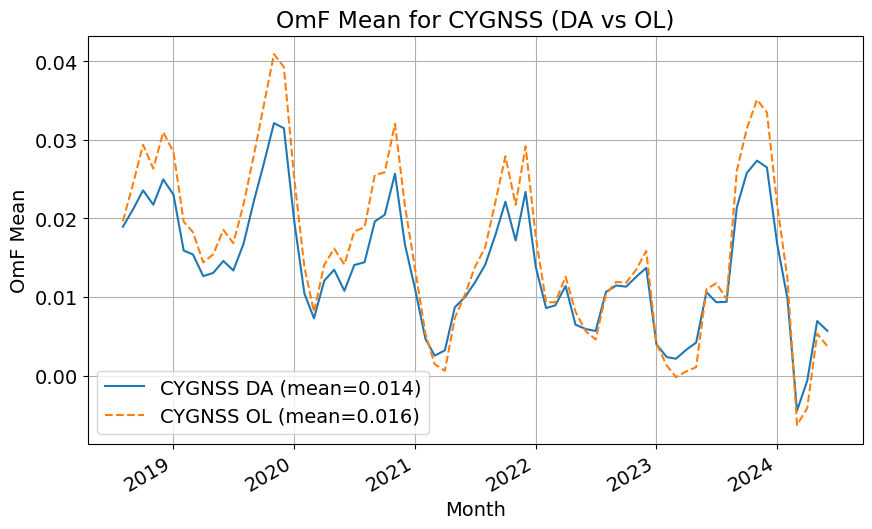

SMOS DA OmF Stdv: [2.897601810105579, 2.307446782251879, 4.224597466535854, 5.343933726109468, 4.23180377050174, 4.158606034216152, 4.143451834336932, 5.510088182066441, 4.257261993279252, 3.8633191039483212, 3.807390026304152, 2.9189247540933017, 2.4181772443775023, 2.6435125732515488, 2.716519592595875, 3.131841966759384, 3.1532560228559534, 6.274098019175695, 5.984759059766713, 5.480313387816677, 4.399958728709265, 4.317779338335884, 2.678020159339967, 2.89704112139001, 4.054853718806376, 3.358731908503627, 4.688032227123574, 3.670227797411761, 6.291457506444176, 6.24589402572733, 5.764496952783571, 6.135696584568584, 3.024511088161447, 3.515148533550167, 4.910390863390307, 3.3304900870405976, 2.7079659650530084, 2.957290159431463, 4.474860444392665, 7.200804199156776, 3.930257633238137, 6.282804074014476, 4.721386042493381, 4.217390107517234, 5.450847233390623, 5.458899494828866, 5.015939215200868, 3.528972548514982, 3.6613613975262864, 5.201943659978281, 5.977162939187351, 4.95372

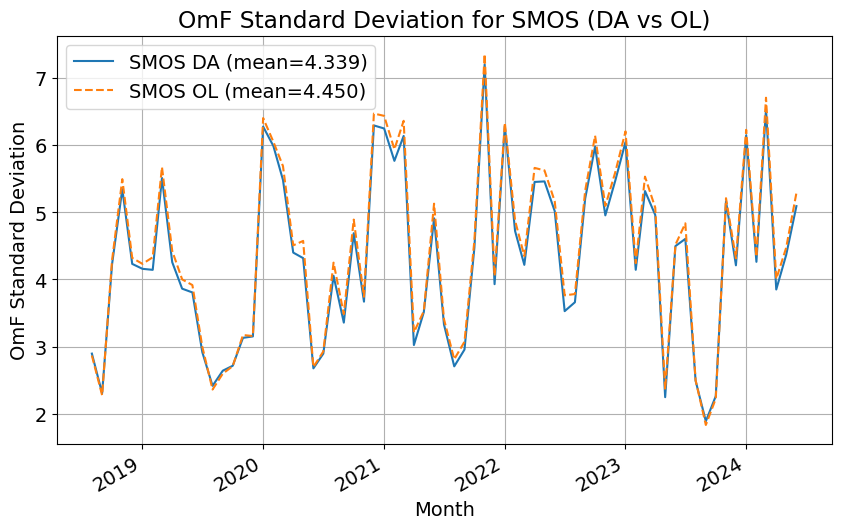

SMAP DA OmF Stdv: [3.1381596836258225, 2.0842853689659093, 4.472255820508173, 6.233859096205332, 4.771982167938086, 4.641541292338674, 4.603924853608348, 6.141212252083744, 4.290987984071419, 4.066855746832751, 3.7504074572769857, 1.4352222911819363, 2.2405018128484437, 2.6212232655640433, 2.8057721644927534, 3.7295515204773664, 3.448736133650499, 7.092397750762856, 6.50380788184701, 6.145801660029125, 4.764701851380824, 5.065526787975381, 2.646778169774959, 2.7340944306809853, 4.618221128507811, 4.145285730949403, 5.537493098149341, 4.024254955060442, 7.387317116361182, 6.6598614140640295, 6.34763375342864, 6.8973009893746555, 2.9949975424708586, 3.6823797763161834, 5.406761465911328, 3.7320365650894907, 2.6580618104774025, 3.3081817307012655, 4.830575954263102, 7.699276228143296, 4.643223979165383, 6.824680601947745, 5.162899904458105, 4.574019780822433, 5.835975972016856, 5.649878364680049, 5.275285723250056, 3.5787835175786773, 2.6011347298786656, 3.291752668721606, 6.6082828063632

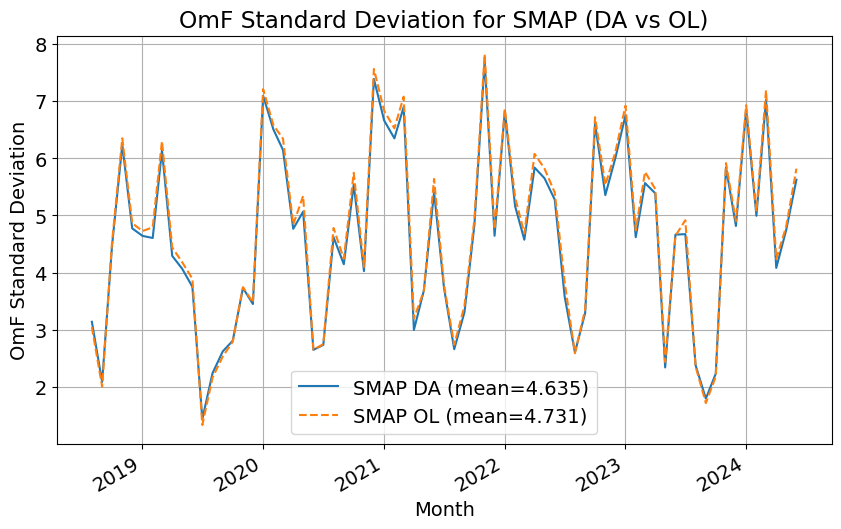

ASCAT DA OmF Stdv: [0.010421595878448852, 0.010507676127895084, 0.014019066408380423, 0.01592433095193203, 0.01587269345953591, 0.015112433305147445, 0.013819114643410936, 0.013793685079634204, 0.012073100780727524, 0.01109526524948331, 0.011113665643770818, 0.010020796129624638, 0.009159104771390305, 0.010427496640754035, 0.011991244618042919, 0.01216913623633314, 0.013075205335987085, 0.01615565977341373, 0.015192789892139453, 0.01451450436802187, 0.012023298398078799, 0.01220055266095693, 0.010458953528288635, 0.010269969280864908, 0.010814838256641457, 0.011992992336133875, 0.014210595689778047, 0.014386758543270798, 0.017820333630695157, 0.01689682796009766, 0.01635324191049014, 0.016633497094503943, 0.012848323436205109, 0.011590803778879128, 0.01271919363174336, 0.011755196751575714, 0.010964416642815972, 0.012008712387120283, 0.014664758441066388, 0.01712764051331303, 0.015110416360617983, 0.017534725121685142, 0.015817419949336213, 0.014286212664286048, 0.012996777615490715, 0

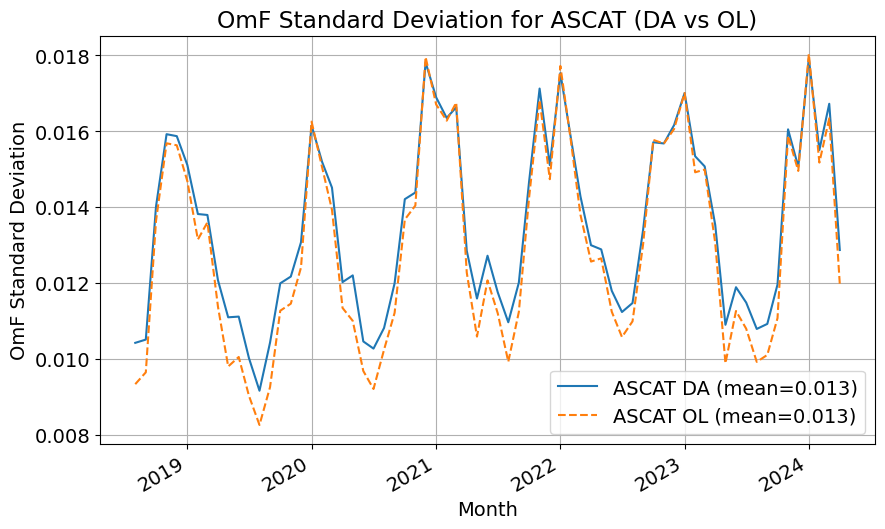

CYGNSS DA OmF Stdv: [0.02031789731875026, 0.0185116360414374, 0.02107924143614959, 0.02371812310163422, 0.022433339479829624, 0.021988316653259364, 0.021321797305765038, 0.02354438606664738, 0.020955606465397115, 0.019902451521010635, 0.020636327971289663, 0.018650118586762347, 0.01797043109847153, 0.018310986671881677, 0.018703168309155214, 0.019552923897954246, 0.020751537746854655, 0.025676807655216703, 0.02418526879058204, 0.022870298348821635, 0.021066811591652627, 0.020803695131131856, 0.0184155110183828, 0.019170564579995154, 0.020163135246274683, 0.019341647783660616, 0.022012450009146877, 0.021451245336194826, 0.026105324603075734, 0.024017439992958658, 0.024707321644678214, 0.024429794532121643, 0.01964226086125058, 0.019636322778904147, 0.01995852772688257, 0.019747189277803626, 0.018041450531974645, 0.018616601169141184, 0.020793802122442716, 0.024553816540219903, 0.02136015161305083, 0.0267125306485379, 0.022885630789105132, 0.02196534333193767, 0.02107336265101245, 0.0213

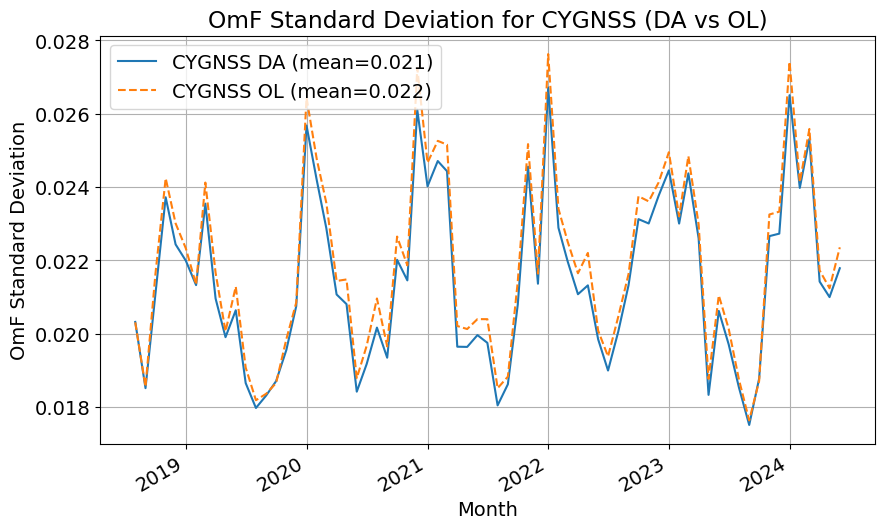

SMOS DA N_data (in millions): [0.118176, 0.116944, 0.121554, 0.116632, 0.119577, 0.120266, 0.108643, 0.120085, 0.11609, 0.121801, 0.118591, 0.119226, 0.120819, 0.118103, 0.122848, 0.117092, 0.121898, 0.117447, 0.110929, 0.119579, 0.118913, 0.121532, 0.116434, 0.121235, 0.121391, 0.116172, 0.122078, 0.118007, 0.119071, 0.119268, 0.10862, 0.119472, 0.11731, 0.119941, 0.116846, 0.121007, 0.119026, 0.116384, 0.120265, 0.114687, 0.11931, 0.11877, 0.109212, 0.119273, 0.117698, 0.117889, 0.117203, 0.119305, 0.118298, 0.114745, 0.120745, 0.115286, 0.119554, 0.11804, 0.107951, 0.120289, 0.117182, 0.121733, 0.117418, 0.120085, 0.121263, 0.099291, 0.120467, 0.115904, 0.118881, 0.118338, 0.090739, 0.101409, 0.117121, 0.118463, 0.113935], Mean: 0.117
SMOS OL N_data (in millions): [0.118105, 0.11694, 0.121552, 0.116624, 0.119571, 0.120256, 0.108626, 0.12005, 0.116016, 0.121499, 0.118321, 0.119159, 0.120741, 0.118085, 0.122837, 0.117058, 0.121894, 0.11744, 0.110899, 0.119575, 0.118842, 0.121107, 0.11

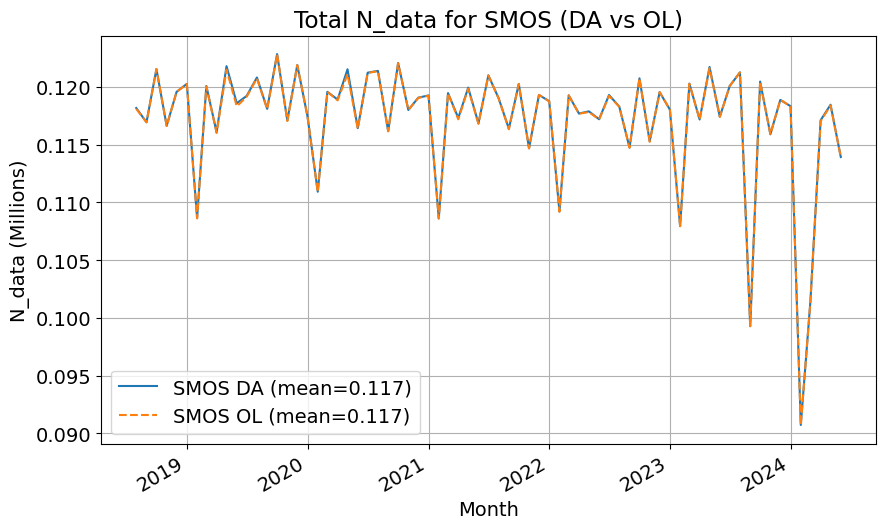

SMAP DA N_data (in millions): [0.279862, 0.268698, 0.284894, 0.264798, 0.275386, 0.278293, 0.253965, 0.281319, 0.277599, 0.278243, 0.155974, 0.074557, 0.281513, 0.276402, 0.287749, 0.266848, 0.283048, 0.276031, 0.262968, 0.278809, 0.270128, 0.280087, 0.270702, 0.277008, 0.283693, 0.273086, 0.285137, 0.265595, 0.263764, 0.280117, 0.253393, 0.276832, 0.277154, 0.284884, 0.276273, 0.281907, 0.285119, 0.27538, 0.283741, 0.270728, 0.276509, 0.274094, 0.256623, 0.279692, 0.270261, 0.282074, 0.276999, 0.280799, 0.046128, 0.079262, 0.281228, 0.241275, 0.27887, 0.278185, 0.247432, 0.270988, 0.275503, 0.275273, 0.265704, 0.282092, 0.285277, 0.26323, 0.28496, 0.265244, 0.281632, 0.279726, 0.262478, 0.274612, 0.278093, 0.283948, 0.265436], Mean: 0.264
SMAP OL N_data (in millions): [0.279862, 0.268698, 0.284894, 0.264798, 0.275386, 0.278292, 0.253965, 0.281317, 0.277599, 0.278228, 0.155939, 0.074557, 0.281504, 0.276402, 0.287749, 0.266848, 0.283048, 0.276031, 0.262967, 0.278809, 0.270127, 0.280058,

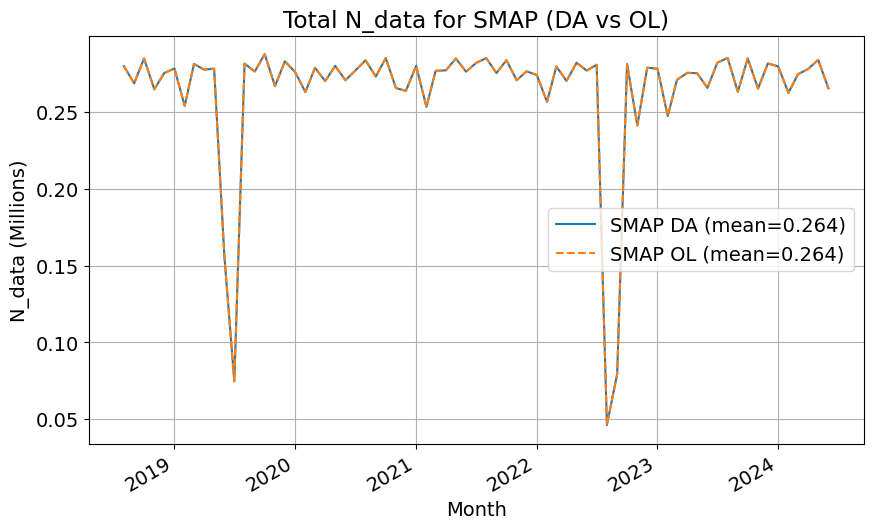

ASCAT DA N_data (in millions): [0.213138, 0.22883, 0.220109, 0.207834, 0.226422, 0.209559, 0.178015, 0.172831, 0.182606, 0.192307, 0.178174, 0.187359, 0.14739, 0.1881, 0.211724, 0.21902, 0.290499, 0.230134, 0.254721, 0.294446, 0.302377, 0.29766, 0.305005, 0.280831, 0.27336, 0.284438, 0.287554, 0.29522, 0.29324, 0.301579, 0.254683, 0.308142, 0.347968, 0.362714, 0.336882, 0.339746, 0.334041, 0.317815, 0.323265, 0.234833, 0.223459, 0.207567, 0.17361, 0.199462, 0.209413, 0.211986, 0.209363, 0.198431, 0.209668, 0.200401, 0.189129, 0.183686, 0.196162, 0.195059, 0.178091, 0.201757, 0.193067, 0.225436, 0.212315, 0.207091, 0.212032, 0.226317, 0.252927, 0.221824, 0.224539, 0.20083, 0.19284, 0.176837, 0.196666, 0.0, 0.0], Mean: 0.229
ASCAT OL N_data (in millions): [0.213118, 0.228829, 0.220109, 0.207834, 0.226422, 0.209559, 0.178015, 0.172831, 0.182606, 0.192303, 0.178136, 0.187343, 0.14738, 0.188098, 0.211724, 0.21902, 0.290499, 0.230134, 0.254721, 0.294446, 0.302377, 0.29765, 0.30496, 0.280772,

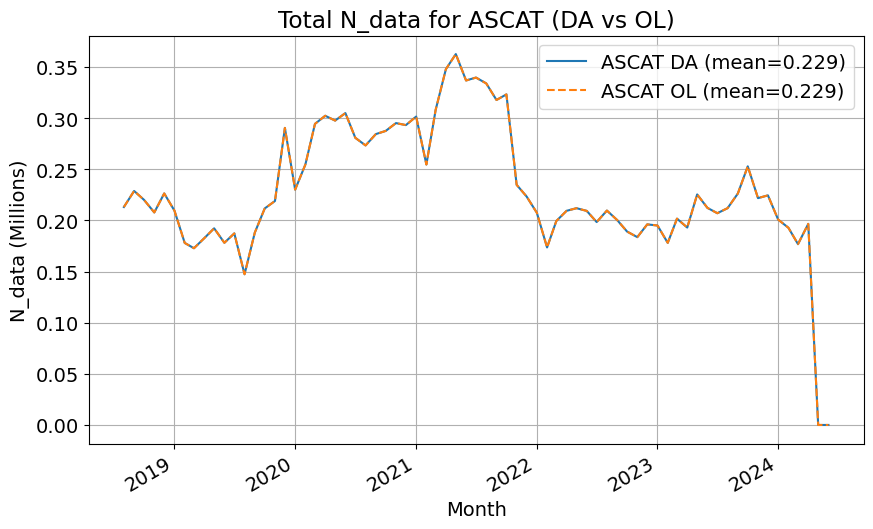

CYGNSS DA N_data (in millions): [0.145215, 0.176181, 0.192144, 0.179941, 0.18783, 0.192045, 0.165565, 0.192284, 0.187213, 0.199205, 0.183982, 0.193427, 0.206933, 0.190802, 0.182114, 0.193475, 0.182825, 0.180155, 0.179956, 0.189954, 0.204428, 0.191035, 0.202902, 0.194422, 0.192759, 0.196235, 0.196877, 0.183401, 0.187458, 0.175971, 0.177292, 0.175811, 0.196489, 0.197492, 0.185672, 0.191713, 0.199614, 0.186903, 0.202025, 0.165463, 0.190519, 0.176446, 0.163803, 0.198491, 0.181867, 0.195448, 0.18005, 0.193541, 0.186973, 0.189403, 0.1766, 0.196599, 0.161508, 0.178037, 0.144003, 0.172106, 0.169354, 0.18072, 0.174363, 0.173914, 0.183391, 0.184106, 0.167355, 0.171057, 0.184471, 0.144497, 0.144268, 0.148461, 0.180092, 0.174047, 0.177715], Mean: 0.182
CYGNSS OL N_data (in millions): [0.145185, 0.176177, 0.192144, 0.179941, 0.18783, 0.192045, 0.165565, 0.192284, 0.187213, 0.199203, 0.183767, 0.193408, 0.206832, 0.1908, 0.182114, 0.193475, 0.182825, 0.180155, 0.179956, 0.189954, 0.204428, 0.191035,

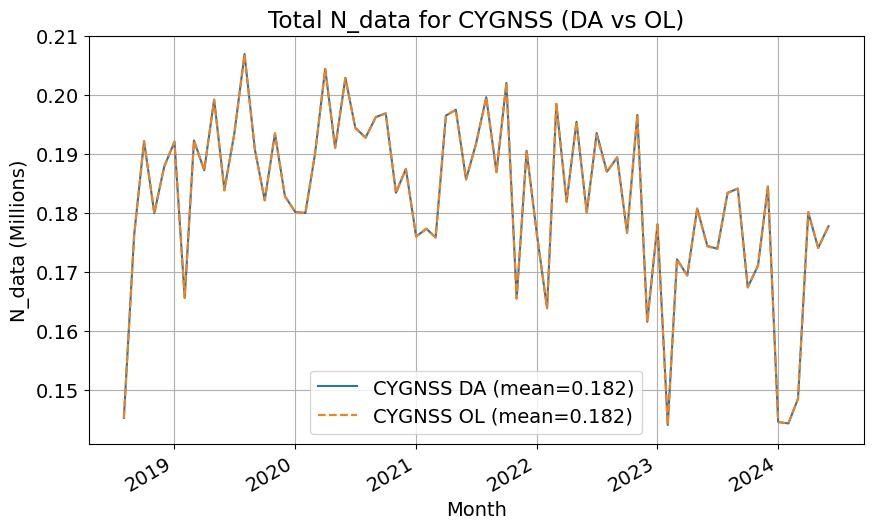

In [20]:

# Plot N_data_group for each species group for both DA and OL experiments on the same plot
plt.figure(figsize=(10, 6))
for group, values in N_data_group_all_months_da.items():
    values_in_millions = [v / 1e6 for v in values]  # Convert to millions
    plt.plot(monthly_timestamps_da, values_in_millions, label=f'{group} DA')
    print(f"{group} DA N_data (in millions): {values_in_millions}")
for group, values in N_data_group_all_months_ol.items():
    values_in_millions = [v / 1e6 for v in values]  # Convert to millions
    plt.plot(monthly_timestamps_ol, values_in_millions, label=f'{group} OL', linestyle='--')
    print(f"{group} OL N_data (in millions): {values_in_millions}")
plt.gcf().autofmt_xdate()
plt.xlabel('Month')
plt.ylabel('N_data (Millions)')
plt.title('Total N_data by Species Group (in Millions) for DA and OL')
plt.legend()
plt.grid()
plt.savefig(out_path + 'N_data_group_OLS_OL.png')  # Save the plot for all groups
plt.show()
plt.close()

# Plot OmF_mean for each species group for both DA and OL experiments on the same plot
for group, values in OmF_mean_all_months_da.items():
    plt.figure(figsize=(10, 6))
    mean_da = np.nanmean(values)
    mean_ol = np.nanmean(OmF_mean_all_months_ol[group])
    plt.plot(monthly_timestamps_da, values, label=f'{group} DA (mean={mean_da:.3f})')
    print(f"{group} DA OmF Mean: {values}, Mean: {mean_da:.3f}")
    plt.plot(monthly_timestamps_ol, OmF_mean_all_months_ol[group], label=f'{group} OL (mean={mean_ol:.3f})', linestyle='--')
    print(f"{group} OL OmF Mean: {OmF_mean_all_months_ol[group]}, Mean: {mean_ol:.3f}")
    plt.gcf().autofmt_xdate()
    plt.xlabel('Month')
    plt.ylabel('OmF Mean')
    plt.title(f'OmF Mean for {group} (DA vs OL)')
    plt.legend()
    plt.grid()
    plt.savefig(out_path + f'OmF_Mean_{group}_OLS_OL.png')  # Save the plot for each group
    plt.show()
    plt.close()

# Plot OmF_stdv for each species group for both DA and OL experiments on the same plot
for group, values in OmF_stdv_all_months_da.items():
    plt.figure(figsize=(10, 6))
    mean_da = np.nanmean(values)
    mean_ol = np.nanmean(OmF_stdv_all_months_ol[group])
    plt.plot(monthly_timestamps_da, values, label=f'{group} DA (mean={mean_da:.3f})')
    print(f"{group} DA OmF Stdv: {values}, Mean: {mean_da:.3f}")
    plt.plot(monthly_timestamps_ol, OmF_stdv_all_months_ol[group], label=f'{group} OL (mean={mean_ol:.3f})', linestyle='--')
    print(f"{group} OL OmF Stdv: {OmF_stdv_all_months_ol[group]}, Mean: {mean_ol:.3f}")
    plt.gcf().autofmt_xdate()
    plt.xlabel('Month')
    plt.ylabel('OmF Standard Deviation')
    plt.title(f'OmF Standard Deviation for {group} (DA vs OL)')
    plt.legend()
    plt.grid()
    plt.savefig(out_path + f'OmF_Stdv_{group}_OLS_OL.png')  # Save the plot for each group
    plt.show()
    plt.close()

# Plot N_data_group for each species group for both DA and OL experiments on separate plots
for group, values in N_data_group_all_months_da.items():
    plt.figure(figsize=(10, 6))
    values_in_millions_da = [v / 1e6 for v in values]  # Convert to millions
    values_in_millions_ol = [v / 1e6 for v in N_data_group_all_months_ol[group]]  # Convert to millions
    mean_da = np.nanmean(values_in_millions_da)
    mean_ol = np.nanmean(values_in_millions_ol)
    plt.plot(monthly_timestamps_da, values_in_millions_da, label=f'{group} DA (mean={mean_da:.3f})')
    print(f"{group} DA N_data (in millions): {values_in_millions_da}, Mean: {mean_da:.3f}")
    plt.plot(monthly_timestamps_ol, values_in_millions_ol, label=f'{group} OL (mean={mean_ol:.3f})', linestyle='--')
    print(f"{group} OL N_data (in millions): {values_in_millions_ol}, Mean: {mean_ol:.3f}")
    plt.gcf().autofmt_xdate()
    plt.xlabel('Month')
    plt.ylabel('N_data (Millions)')
    plt.title(f'Total N_data for {group} (DA vs OL)')
    plt.legend()
    plt.grid()
    plt.savefig(out_path + f'N_data_{group}_OLS_OL.png')  # Save the plot for each group
    plt.show()
    plt.close()  


In [21]:
import sys
sys.path.append('../Jupyter')
from mapper_functions import plot_global_tight_pcm, plot_aus_tight_pcm

lat = tc['com_lat']
lon = tc['com_lon']

# Determine the number of tiles based on the latitude array
n_tile = len(lat)

# Initialize an observation array with NaN values
# The array has dimensions [n_tile, 3], where:
# - Column 0 is reserved for future use
# - Column 1 stores longitude values
# - Column 2 stores latitude values
map_array = np.empty([n_tile, 3])
map_array.fill(np.nan)
map_array[:, 1] = lon
map_array[:, 2] = lat

 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_SMOS_Tb_Max_27_9_Min_17_1_.png 



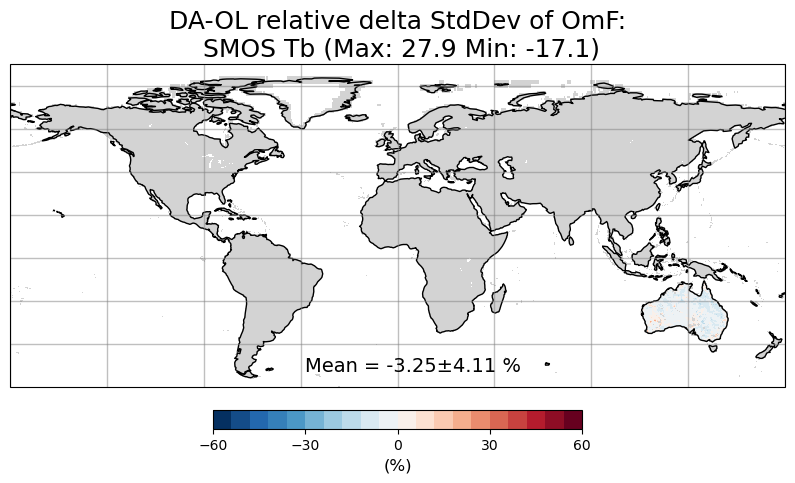

 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_SMOS_Tb_Max_27_9_Min_17_1_.png 



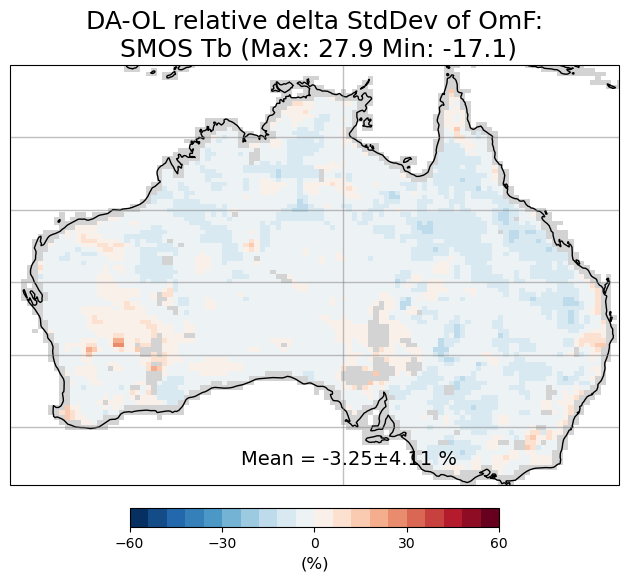

In [22]:

group_id = 'SMOS'

# Avoid division by zero by replacing zeros in the denominator with np.nan
denominator = np.array(group_metrics_ol[group_id]['OmF_stdv'])
denominator[denominator == 0] = np.nan

# Compute the percentage difference safely
map_array[:, 0] = ((np.array(group_metrics_da[group_id]['OmF_stdv']) - denominator) / denominator) * 100

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_global_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} Tb (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)

plot_aus_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} Tb (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)


 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_SMAP_Tb_Max_24_9_Min_18_3_.png 



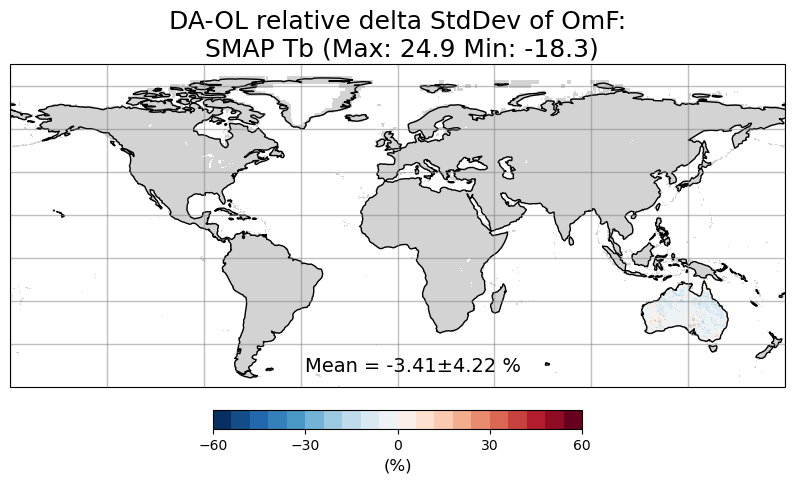

 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_SMAP_Tb_Max_24_9_Min_18_3_.png 



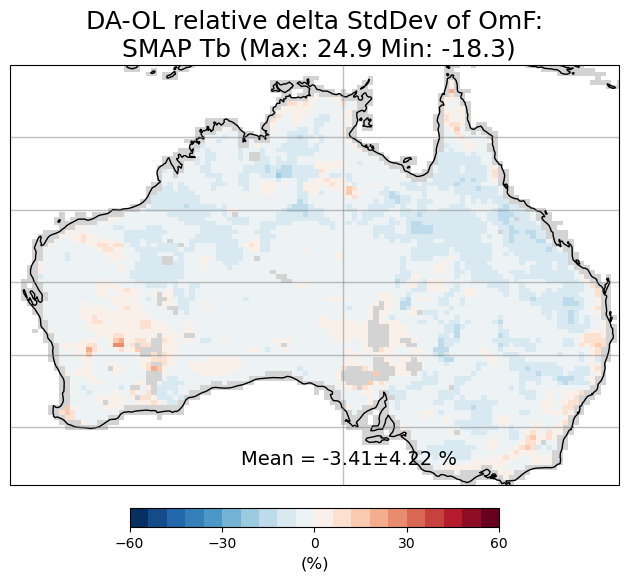

In [23]:

group_id = 'SMAP'

# Avoid division by zero by replacing zeros in the denominator with np.nan
denominator = np.array(group_metrics_ol[group_id]['OmF_stdv'])
denominator[denominator == 0] = np.nan

# Compute the percentage difference safely
map_array[:, 0] = ((np.array(group_metrics_da[group_id]['OmF_stdv']) - denominator) / denominator) * 100

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_global_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} Tb (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)

plot_aus_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} Tb (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)


 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_ASCAT_SM_Max_136_Min_26_5_.png 



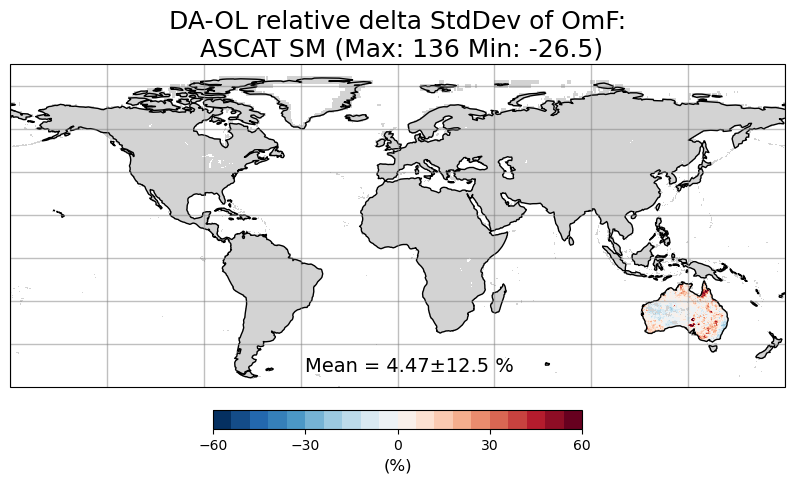

 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_ASCAT_SM_Max_136_Min_26_5_.png 



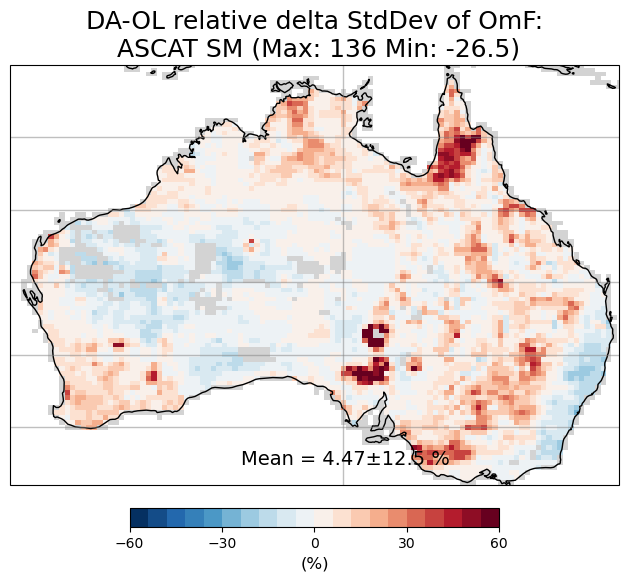

In [24]:
group_id = 'ASCAT'

# Avoid division by zero by replacing zeros in the denominator with np.nan
denominator = np.array(group_metrics_ol[group_id]['OmF_stdv'])
denominator[denominator == 0] = np.nan

# Compute the percentage difference safely
map_array[:, 0] = ((np.array(group_metrics_da[group_id]['OmF_stdv']) - denominator) / denominator) * 100

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_global_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)

plot_aus_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)


 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_CYGNSS_SM_Max_134_Min_37_2_.png 



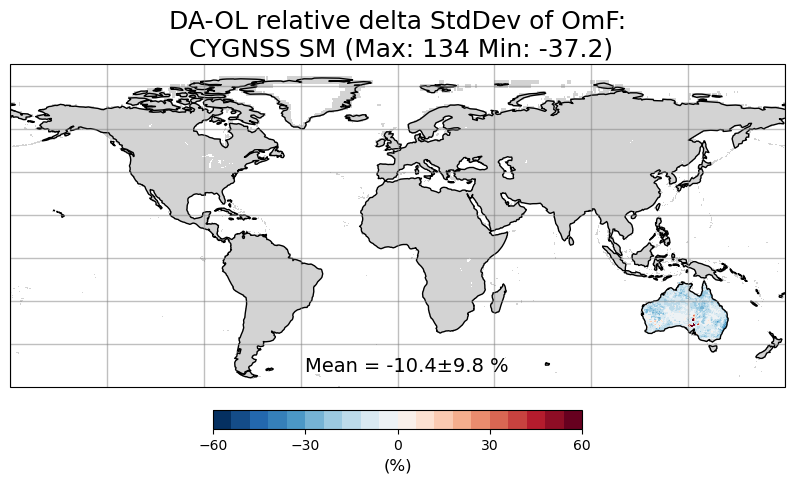

 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_CYGNSS_SM_Max_134_Min_37_2_.png 



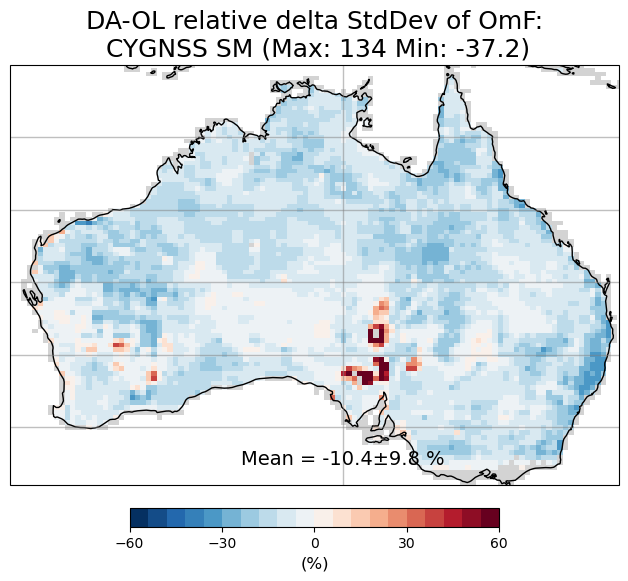

 Saving figure as DA_OL_relative_delta_StdDev_of_OmF_CYGNSS_SM_SMAP_mask_Max_53_Min_35_2_.png 



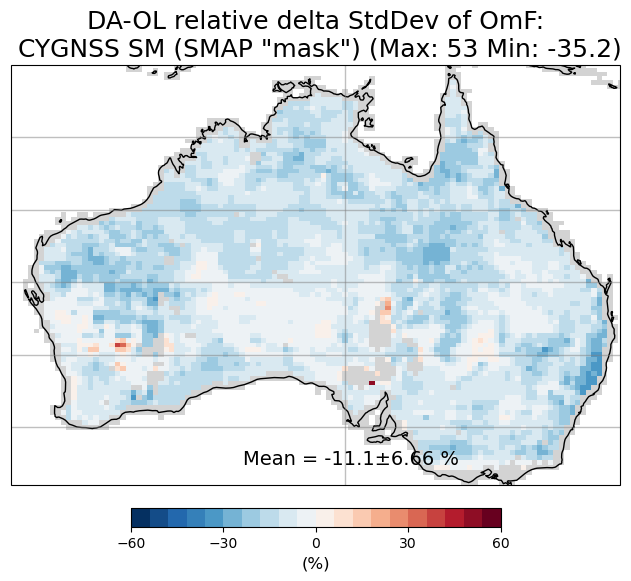

In [36]:
group_id = 'CYGNSS'

# Avoid division by zero by replacing zeros in the denominator with np.nan
denominator = np.array(group_metrics_ol[group_id]['OmF_stdv'])
denominator[denominator == 0] = np.nan

# Compute the percentage difference safely
map_array[:, 0] = ((np.array(group_metrics_da[group_id]['OmF_stdv']) - denominator) / denominator) * 100

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_global_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)

plot_aus_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)

mask = np.array(group_metrics_ol['SMAP']['OmF_stdv'])
mask = np.where(~np.isnan(mask), 1, np.nan)

map_array[:, 0] = map_array[:, 0]* mask
# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_aus_tight_pcm(map_array, True, True, f'DA-OL relative delta StdDev of OmF:\n {group_id} SM (SMAP "mask") (Max: {maxval:.3g} Min: {minval:.3g})', '%', -60, 60)

 Saving figure as Number_of_observations_CYGNSS_SM_Max_2_96e_03_Min_5_.png 



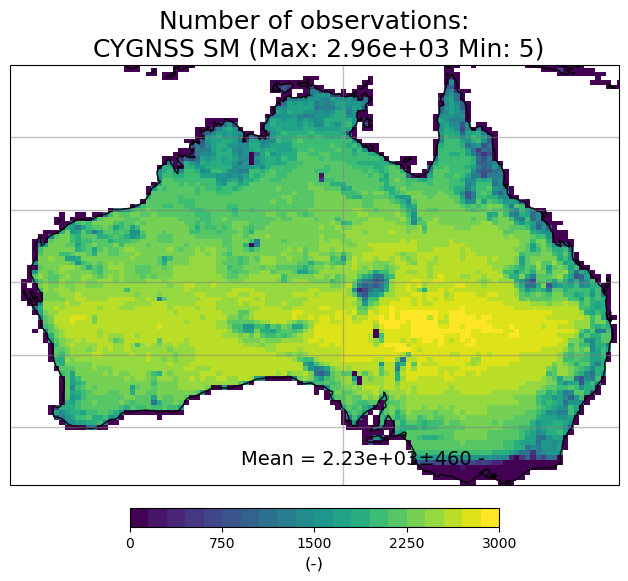

 Saving figure as OL_OmF_Mean_CYGNSS_SM_Max_0_401_Min_0_122_.png 



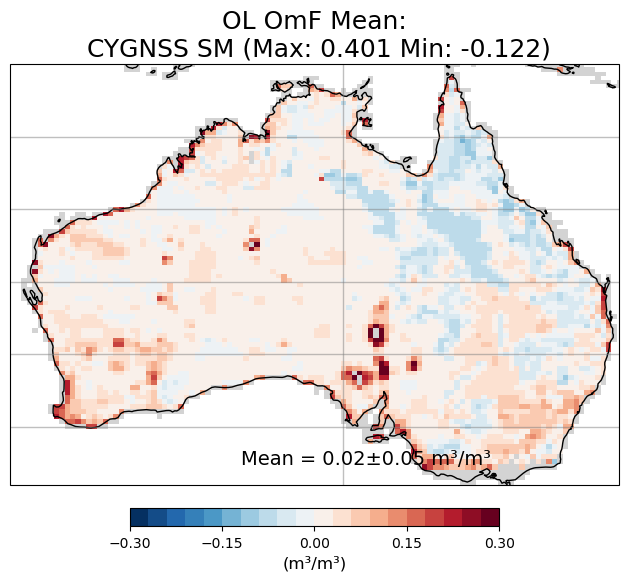

 Saving figure as DA_OmF_Mean_CYGNSS_SM_Max_0_253_Min_0_113_.png 



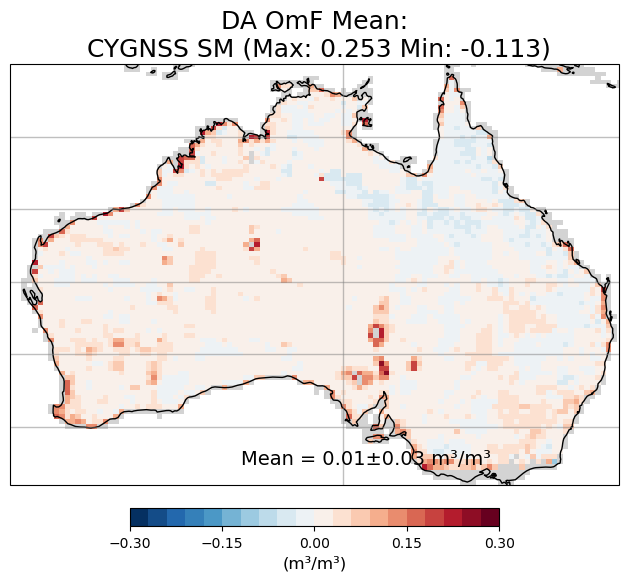

 Saving figure as OL_OmF_StDv_CYGNSS_SM_Max_0_116_Min_0_0128_.png 



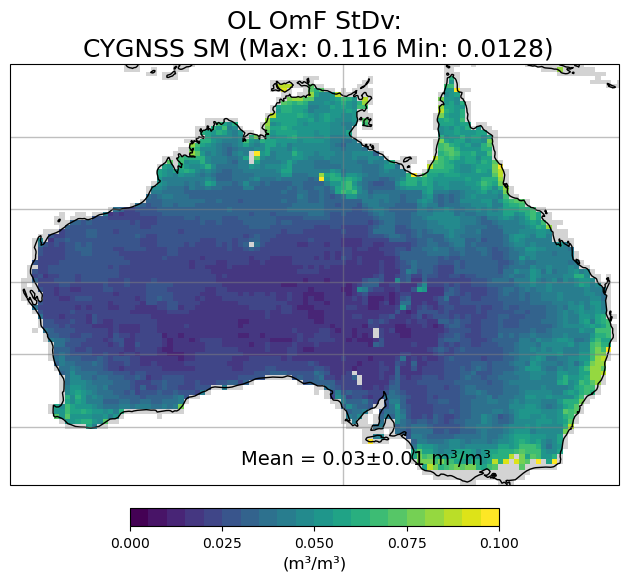

 Saving figure as DA_OmF_StDv_CYGNSS_SM_Max_0_11_Min_0_0125_.png 



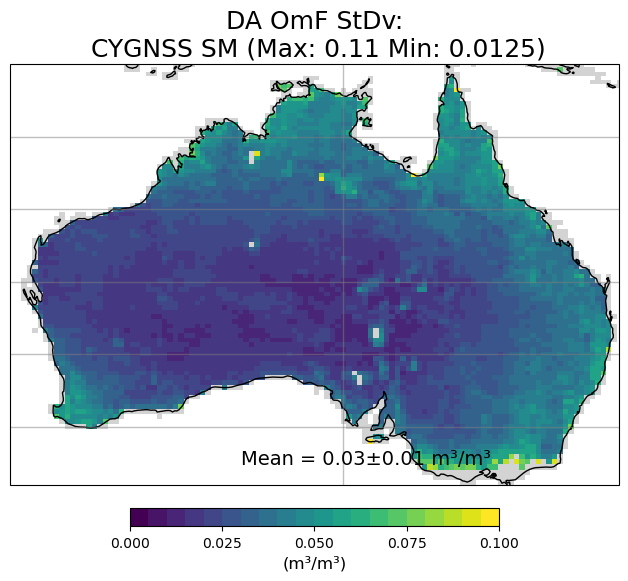

In [ ]:
group_id = 'CYGNSS'

denominator = np.array(group_metrics_ol[group_id]['Nobs_data'])
denominator[denominator == 0] = np.nan

map_array[:, 0] = denominator

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_aus_tight_pcm(map_array, True, True, f'Number of observations:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', '-', 0, 3000)

denominator = np.array(group_metrics_ol[group_id]['OmF_mean'])
denominator[denominator == 0] = np.nan

map_array[:, 0] = denominator

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_aus_tight_pcm(map_array, True, True, f'OL OmF Mean:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', 'm³/m³', -0.3, 0.3)

denominator = np.array(group_metrics_da[group_id]['OmF_mean'])
denominator[denominator == 0] = np.nan

map_array[:, 0] = denominator

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_aus_tight_pcm(map_array, True, True, f'DA OmF Mean:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', 'm³/m³', -0.3, 0.3)

denominator = np.array(group_metrics_ol[group_id]['OmF_stdv'])
denominator[denominator == 0] = np.nan

map_array[:, 0] = denominator

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_aus_tight_pcm(map_array, True, True, f'OL OmF StDv:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', 'm³/m³', 0, 0.1)

denominator = np.array(group_metrics_da[group_id]['OmF_stdv'])
denominator[denominator == 0] = np.nan

map_array[:, 0] = denominator

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_aus_tight_pcm(map_array, True, True, f'DA OmF StDv:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', 'm³/m³', 0., 0.1)



 Saving figure as _DA_OL_OmF_StDv_OL_CYGNSS_SM_Max_1_34_Min_0_372_.png 



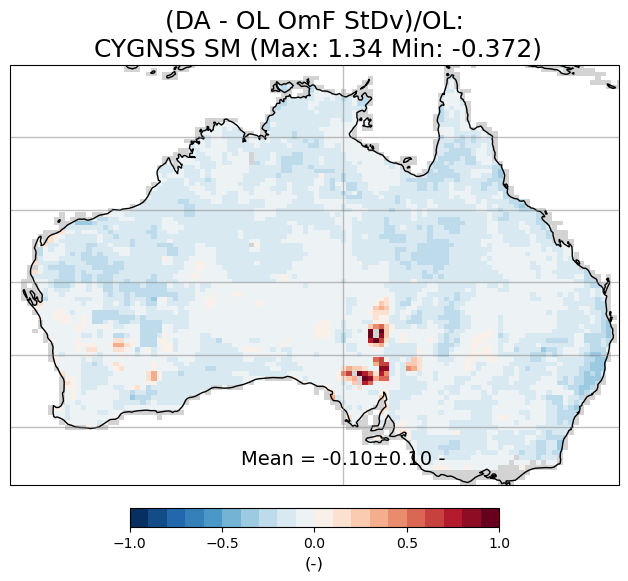

In [38]:

denominator = np.array(group_metrics_ol[group_id]['OmF_stdv'])
denominator[denominator == 0] = np.nan

map_array[:, 0] = (np.array(group_metrics_da[group_id]['OmF_stdv']) - denominator) / denominator

# Calculate max and min values, ignoring NaNs
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

plot_aus_tight_pcm(map_array, True, True, f'(DA - OL OmF StDv)/OL:\n {group_id} SM (Max: {maxval:.3g} Min: {minval:.3g})', '-', -1, 1)